In [2]:
import sys 
import os
#sys.path.append(os.path.abspath("/home/pcs/patrick/Dokumente/Github/colormap/"))
sys.path.append(os.path.abspath("C:\Users\User\Documents\GitHub/colormap/"))
import colormaps as cmaps

In [3]:
from __future__ import division

In [4]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

In [5]:
import numpy as np
import scipy.constants as cs
import scipy.special as ss
import scipy.optimize as so
from matplotlib import pyplot as plt
from matplotlib import cm
from qkit.qkit.gui.notebook.Progress_Bar import Progress_Bar as pb
from scipy.integrate import dblquad
from scipy import integrate
import math as math

%matplotlib inline

In [6]:
#customized plots:
import matplotlib 
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
matplotlib.rc('text', usetex=True)

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (8.0,5.0)
matplotlib.rcParams['savefig.dpi'] = 100
matplotlib.rcParams['legend.shadow'] = True
matplotlib.rcParams['savefig.bbox'] = 'tight'




cmap_virdis = cmaps.viridis.colors





In [7]:
rb_colors = cm.rainbow(np.linspace(0, 1, 20))

In [8]:
labelsize = 27

In [9]:
mu_0 = cs.mu_0
mu_B = cs.physical_constants['Bohr magneton'][0]   #Bohr magneton in SI units
k_b = cs.k

## Wire length

In [10]:
def coil_length(n, n_layer, d_wire, R_min):
    '''function to estimate the total wire length'''
    l = 0.
    R = R_min
    for i in range(n_layer):
        for j in range(n):
            l += 2.*np.pi*R
        R +=d_wire
    return l

## Magnetic field: radial component

In [11]:
#remark: calculation fails if r = 0 and k = 0

def B_r(r,z,z0, I, R, N):
    #B_amp = mu_0*I*R**2./2.
    B_amp = mu_0*I*R**2.*(z-z0)/(2.*np.sqrt((z-z0)**2.))      #introduced a z dependent factor equal to one z/np.sqrt(z**2) but with different sign 
    B = np.float64(0)                                         #below and above the loop
    if np.abs(z-z0) <= 10**(-7):
        #print 'Encountered small number'
        return np.float64(0.)
    else:
        try:
            for k in range(N):
                if r == 0:
                    k +=1
                B += (-1.)**(k+1.)*k*np.power(r,(2.*k-1.))/(2.**k*math.factorial(k))**2.*np.power((z-z0),(-2.*(k+1)))*ss.gamma(2.*(k+1.))*ss.hyp2f1(k+1,k+3/2.,2., -(R/(z-z0))**2)
            return B_amp*B
        except (RuntimeWarning, ZeroDivisionError):  #changed (-2.*(k+1)) to (-2*k+1)
            print 'ZeroDivisionError encountered' 


In [12]:
'''
#remark: calculation fails if r = 0 and k = 0

def B_r(r,z,z0, I, R, N):
    B_amp = mu_0*I*R**2./2.
    B = np.float64(0)
    for k in range(N):
        if r == 0:
            k +=1
        B += (-1.)**(k+1.)*k*np.power(r,(2.*k-1.))/(2.**k*math.factorial(k))**2.*np.power((z-z0),(-2.*(k+1)))*ss.gamma(2.*(k+1.))*ss.hyp2f1(k+1,k+3/2.,2., -R**2./(z-z0)**2)
    return B_amp*B
'''



'\n#remark: calculation fails if r = 0 and k = 0\n\ndef B_r(r,z,z0, I, R, N):\n    B_amp = mu_0*I*R**2./2.\n    B = np.float64(0)\n    for k in range(N):\n        if r == 0:\n            k +=1\n        B += (-1.)**(k+1.)*k*np.power(r,(2.*k-1.))/(2.**k*math.factorial(k))**2.*np.power((z-z0),(-2.*(k+1)))*ss.gamma(2.*(k+1.))*ss.hyp2f1(k+1,k+3/2.,2., -R**2./(z-z0)**2)\n    return B_amp*B\n'

## Magnetic field: z-component

In [13]:
#still wrong for z-z0 = 0 since the solution does not depend on r and is only valid for 
#r = 0. Therefore the dimension of the used arrays for r and z should be even!

def B_z(r,z,z0, I, R, N):
    B_amp = mu_0*I*R**2./2.
    B = np.float64(0)
    if np.abs(z-z0) <= 10**(-7):
        #print 'Encountered small number'
        return mu_0*I*R**2./(2.*(R**2.)**(3./2.))
    else:
        try:
            for k in range(N):
                B += (-1.)**(k)*(k+1.)*np.power(r,(2.*k))/(2.**k*math.factorial(k))**2.*np.power(np.abs(z-z0),(-(2.*k+3.)))*ss.gamma(2.*(k+1.))*ss.hyp2f1(k+3/2.,k+2.,2., -(R/(z-z0))**2.)
            return B_amp*B
        except (RuntimeWarning, ZeroDivisionError):  
            print 'ZeroDivisionError encountered' 
        

In [14]:

'''
def B_z(r,z,z0, I, R, N):
    B_amp = mu_0*I*R**2./2.
    B = np.float64(0)
    for k in range(N):
        B += (-1.)**(k)*(k+1.)*np.power(r,(2.*k))/(2.**k*math.factorial(k))**2.*np.power(np.abs(z-z0),(-(2.*k+3.)))*ss.gamma(2.*(k+1.))*ss.hyp2f1(k+3/2.,k+2.,2., -R**2./(z-z0)**2)
    return B_amp*B
    
'''
        

'\ndef B_z(r,z,z0, I, R, N):\n    B_amp = mu_0*I*R**2./2.\n    B = np.float64(0)\n    for k in range(N):\n        B += (-1.)**(k)*(k+1.)*np.power(r,(2.*k))/(2.**k*math.factorial(k))**2.*np.power(np.abs(z-z0),(-(2.*k+3.)))*ss.gamma(2.*(k+1.))*ss.hyp2f1(k+3/2.,k+2.,2., -R**2./(z-z0)**2)\n    return B_amp*B\n    \n'

In [15]:
z0 = 4*10**-3

In [16]:
t1 = B_r(0.,z0+0.2, z0,1.,0.5,20)

In [17]:
t = B_z(0.,z0, z0,1.,0.5,20)

### First test: single loop

In [18]:
#r = 0.0
I = 1.
R = 0.008
#z0 = 0.0025
N_sq = 100
z = np.linspace(-R,R,N_sq+1)
r = np.linspace(-0.9*R,0.9*R,N_sq+1)
N_acc = 20

In [19]:
Br = []
Bz = []
for z1 in z:
    Br.append(B_r(0.1*R,z1,z0,I,R,N_acc))
    Bz.append(B_z(0.1*R,z1,z0,I,R,N_acc))
    
Br = np.array(Br)
Bz = np.array(Bz)

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


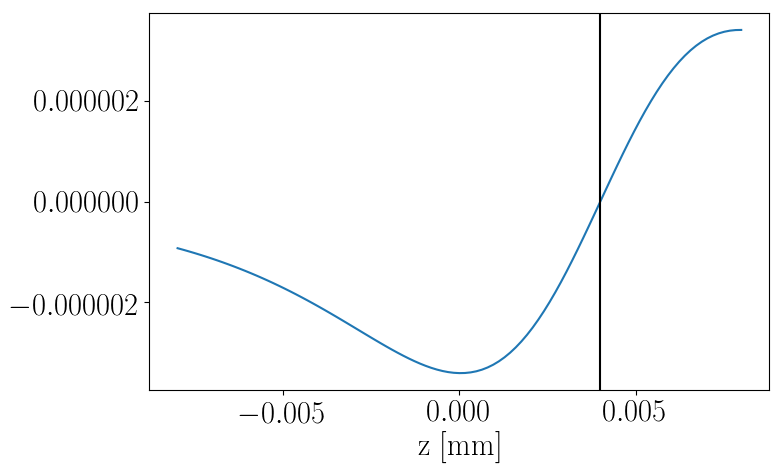

In [20]:
plt.plot(z, Br[:])
plt.axvline(z0, color = 'black')
plt.xlabel('z [mm]')

In [21]:
Br = []

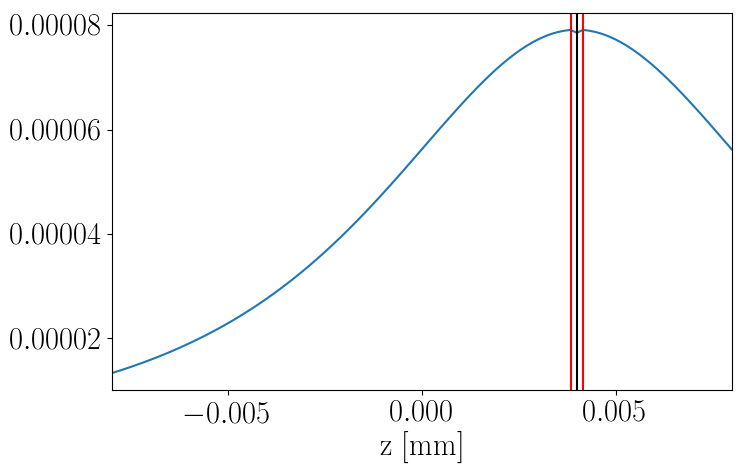

In [22]:
plt.plot(z, Bz)
plt.xlim(-R,R)
plt.axvline(z0, color = 'black')
plt.axvline(z0-(np.max(z)-np.min(z))/len(z), color = 'red')
plt.axvline(z0+(np.max(z)-np.min(z))/len(z), color = 'red')
plt.xlabel('z [mm]')

In [23]:
Brr = []
Bzr = []
Bzr2 = []
for r1 in r:
    Brr.append(B_r(r1,0.011,0.01,I,R,N_acc))
    Bzr.append(B_z(r1,0.011,0.01,I,R,N_acc))
    Bzr2.append(B_z(r1,0.00,0.01,I,R,N_acc))
    
Brr = np.array(Brr)
Bzr = np.array(Bzr)
Bzr2 = np.array(Bzr2)

In [24]:
r11 = np.linspace(-0.9*R,0.9*R,100)
z11 = np.linspace(-R,R,100)
X,Y = np.meshgrid(r11,z11)

In [25]:
r01 = np.linspace(-0.9*R,0.9*R,101)
z01 = np.linspace(-R,R,101)
X01,Y01 = np.meshgrid(r01,z01)

In [26]:
Brr = []
Bz2D = []
Br2D = []
#z0 = 0
for z1 in z11:
    Bzr = []
    Brr = []
    for r1 in r11:
        Brr.append(B_r(r1,z1,0,I,R,N_acc))
        Bzr.append(B_z(r1,z1,0,I,R,N_acc))
    Bz2D.append(Bzr)
    Br2D.append(Brr)
Bz2D = np.array(Bz2D)
Br2D = np.array(Br2D)

C:\Program Files\Anaconda2\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


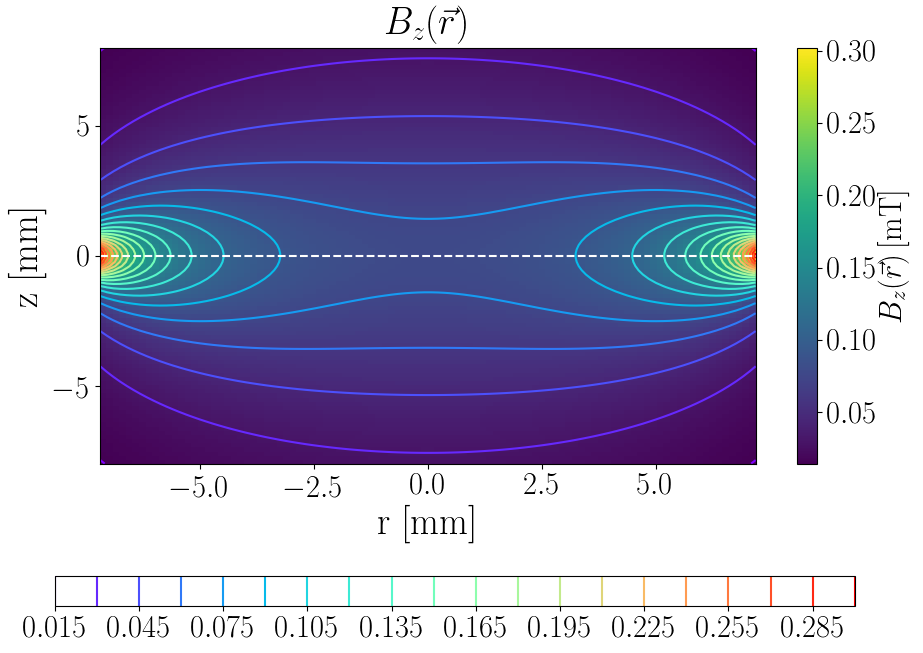

In [27]:
figBzSC, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_z(\vec{r})$', fontsize = labelsize)
ax.set_xlabel('r [mm]', fontsize = labelsize)
ax.set_ylabel('z [mm]', fontsize = labelsize)
ax.set_xlim(-0.9*R*10**3,0.9*R*10**3)
ax.set_ylim(-R*10**3,R*10**3)
ax.axhline(0, color = 'white', ls = '--')
#ax.axes.set_aspect('equal')
cd = plt.pcolor(X01*10**3,Y01*10**3,Bz2D*10**3, cmap=plt.get_cmap(cmaps.viridis))
cs = plt.contour(r11*10**3,z11*10**3,Bz2D*10**3, 20, lw = 2.,  colors = rb_colors)
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[mT]}$')

# make a colorbar for the contour lines
cbaxes = figBzSC.add_axes([0.1, -0.05, 0.8, 0.05])
CB = plt.colorbar(cs, orientation = 'horizontal', cax = cbaxes)

 


plt.tight_layout()

In [28]:
#figBzSC.savefig('BzSC_con_cb.png', dpi = 200)

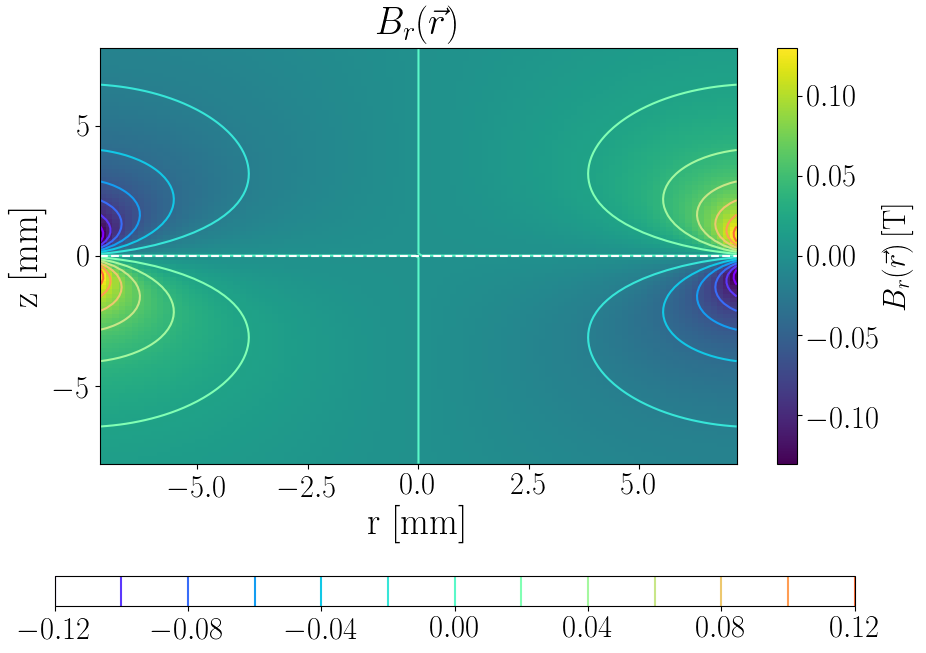

In [29]:
figBrSC, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_r(\vec{r})$', fontsize = labelsize)
ax.set_xlabel('r [mm]', fontsize = labelsize)
ax.set_ylabel('z [mm]', fontsize = labelsize)
ax.set_xlim(-0.9*R*10**3,0.9*R*10**3)
ax.set_ylim(-R*10**3,R*10**3)
ax.axhline(0, color = 'white', ls = '--')
#ax.axes.set_aspect('equal')
cs = plt.contour(r11*10**3,z11*10**3,Br2D*10**3, 15, colors = cm.rainbow(np.linspace(0, 1, len(range(15)))))
cd = plt.pcolor(X01*10**3,Y01*10**3,Br2D*10**3, cmap=plt.get_cmap(cmaps.viridis))
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_r(\vec{r})\,\mathrm{[T]}$')

# make a colorbar for the contour lines
cbaxes = figBrSC.add_axes([0.1, -0.05, 0.8, 0.05])
CB = plt.colorbar(cs, orientation = 'horizontal', cax = cbaxes)


plt.tight_layout()

In [30]:
#figBrSC.savefig('BrSC_con_cb.png', dpi = 200)

## Single Coil

In [31]:
def B_SC(r,z,z0,I,R,N):
    '''
    magnetic field of a coil with a single loop
    
    d_wire: wire diameter
    r: radial direction/dimensions
    z: vertical direction/dimensions
    z0: vertical start position
    I: max. current
    R: initial coil radius
    N: number of sqaures'''
    Bz2D = []
    Br2D = []
    for z1 in z:
        Bzr = []
        Brr = []
        for r1 in r:
            Brr.append(B_r(r1,z1,z0,I,R,N))
            Bzr.append(B_z(r1,z1,z0,I,R,N))
        Bz2D.append(Bzr)
        Br2D.append(Brr)
    Bz2D = np.array(Bz2D, dtype=np.float64)
    Br2D = np.array(Br2D, dtype=np.float64)
    return np.array([Bz2D, Br2D],dtype=np.float64)

In [32]:
Bz = B_SC(r,z,z0,I,R,N_acc)[0][0]

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


In [33]:
#plt.plot(z, Bz)
#plt.plot(z11, Bz2D[0])

## Helmholtz like geometry (two coils):

In [34]:
def B_HH(n,n_layer,d_wire,r,z,z0,I,R,N):
    '''magnetic field of a coil of n*n_layer windings, each winding is represented 
    by an individual single loop coil
    
    n: number of windings per layer
    n_layer: total number of layer
    d_wire: wire diameter
    r: radial direction/dimensions
    z: vertical direction/dimensions
    z0: vertical start position
    I: max. current
    R: initial coil radius
    N: number iterations'''
    Ndimr = len(r)
    Ndimz = len(z)
    B_HHr = np.zeros([Ndimr,Ndimz])
    B_HHz = np.zeros([Ndimr,Ndimz])
    p1 = pb(n*n_layer)
    if(z0 >= 0):    #distrincion between a coil above or below the waveguide
        k = 1.
    else: k = -1.
    for j in range(n_layer):
        #print
        #print R
        #print
        for i in range(n):
            B_HHz += B_SC(r,z,z0,I,R,N)[0]
            B_HHr += B_SC(r,z,z0,I,R,N)[1]
            #print z0
            p1.iterate()
            z0+=k*d_wire   #the vertical position changes with each added winding/loop
        z0 -= k*n*d_wire   #
        R += d_wire  #the coil radius increases with every added layer of windings
    return np.array([B_HHz, B_HHr], dtype = np.float64)
        
        
    

### Coil and wire dimensions

In [35]:
R = 10.*10**(-3)                   #coil radius in m
d_wire = 0.13*10**(-3.)           #wire diameter in m
I_max = 1.                        #max. current in amps
n = 35                           #number of windings per layer
n_layer = 35                      #number of layer
wg_height = 6.*10**(-3)            #waveguide height
wg_thickness = 2.*10**(-3)       #waveguide wall thickness 
z0 = wg_height/2.+wg_thickness    #vertical position of coil
print z0

0.005


In [36]:
print 'coil height: h = {} mm '.format(n*d_wire*10**3)
print 'winding thickness: t = {} mm'.format(n_layer*d_wire*10**3)
print 'coil diamter: d = {} mm'.format((2.*n_layer*d_wire+2.*R)*10**3)

coil height: h = 4.55 mm 
winding thickness: t = 4.55 mm
coil diamter: d = 29.1 mm


In [37]:
coil_height = 4*10**-3.           #coil height with boundary (0.5 mm thick copper)
coil_height_WOB = 5.*10**-3.       #coil height without boundary (using teflon washer)
Ri = R                            #inner radius (coil)
Ro = 14.75*10**-3                 #outer radius (coil)

In [38]:
N = coil_height/d_wire         #number of windings per layer
N_WOB = coil_height_WOB/d_wire
print 'N = {}'.format(N)
print 'N_WOB = {}  (without bounday)'.format(N_WOB)

N = 30.7692307692
N_WOB = 38.4615384615  (without bounday)


In [39]:
N_L = (Ro-Ri)/d_wire               #number of layers
print N_L

36.5384615385


In [40]:
N_tot = int(N)*N_L
N_tot_WOB = int(N_WOB)*N_L
print 'N_tot = {}'.format(N_tot)
print 'N_tot = {}  (without bounday)'.format(N_tot_WOB)

N_tot = 1096.15384615
N_tot = 1388.46153846  (without bounday)


In [41]:
coil_length(int(N), int(N_L), d_wire, Ri)

83.29618761727934

In [42]:
coil_length(int(N_WOB), int(N_L), d_wire, Ri)

105.5085043152207

In [43]:
2.*np.pi*Ri*N_tot

68.87337740562239

### Coarse simulation for testing

In [44]:
N_small = 10
r_small = np.linspace(-0.9*R,0.9*R,N_small)
z_small = np.linspace(-R,R,N_small)
rx_small = np.linspace(-0.9*R,0.9*R,N_small+1)
zx_small = np.linspace(-R,R,N_small+1)
X_small,Y_small = np.meshgrid(rx_small,zx_small)

In [45]:
B_small = np.array(B_HH(10,10,d_wire,r_small,z_small,z0,I_max,R,N_acc))+np.array(B_HH(10,10,d_wire,r_small,z_small,-z0,I_max,R,N_acc))

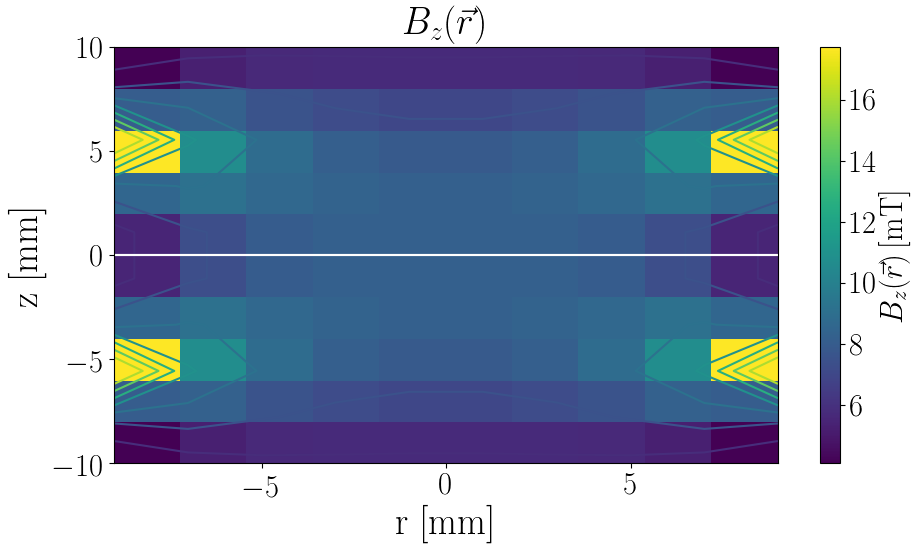

In [46]:
figBz, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_z(\vec{r})$', fontsize = labelsize)
ax.set_xlabel('r [mm]', fontsize = labelsize)
ax.set_ylabel('z [mm]', fontsize = labelsize)
ax.set_xlim(-0.9*R*10**3,0.9*R*10**3)
ax.set_ylim(-R*10**3,R*10**3)
ax.axhline(z0, color = 'white')
ax.axhline(-z0, color = 'white')
#ax.axes.set_aspect('equal')
C2 = plt.contour(r_small*10**3, z_small*10**3, B_small[0]*10**3,10)
cd = plt.pcolor(rx_small*10**3,zx_small*10**3,B_small[0]*10**3, cmap=plt.get_cmap(cmaps.viridis))
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[mT]}$')
plt.tight_layout()

### data calculation:

In [47]:
N_sq1 = 50
r02 = np.linspace(-0.9*R,0.9*R,N_sq1)
z02 = np.linspace(-R,R,N_sq1)
X1,Y1 = np.meshgrid(r02,z02)


r03 = np.linspace(-0.9*R,0.9*R,N_sq1+1)
z03 = np.linspace(-R,R,N_sq1+1)
X2,Y2 = np.meshgrid(r03,z03)

In [101]:
R_prime = R+2*10**-3
z_prime= z0 + 1.*10**-3

In [48]:
'''

B = np.array(B_HH(n,n_layer,d_wire,r02,z02,z0,I_max,R,N_acc))+np.array(B_HH(n,n_layer,d_wire,r02,z02,-z0,I_max,R,N_acc))


try:
    BR2 = np.array(B_HH(n,n_layer,d_wire,r02,z02,z0,I_max,R_prime,N_acc))+np.array(B_HH(n,n_layer,d_wire,r02,z02,-z0,I_max,R_prime,N_acc))
except:
    print 'error'

try:
    Bwgh = np.array(B_HH(n,n_layer,d_wire,r02,z02,z_prime,I_max,R,N_acc))+np.array(B_HH(n,n_layer,d_wire,r02,z02,-z_prime,I_max,R,N_acc))
except:
    print 'error'
    
try:
    Bwgh2 = np.array(B_HH(n,n_layer,d_wire,r02,z02,z_prime,I_max,R_prime,N_acc))+np.array(B_HH(n,n_layer,d_wire,r02,z02,-z_prime,I_max,R_prime,N_acc))
except:
    print 'error'
    
try:
    BRext = np.array(B_HH(n,n_layer,d_wire,r02,z02,z0,I_max,R+5*10**(-3),N_acc))+np.array(B_HH(n,n_layer,d_wire,r02,z02,-z0,I_max,R+5*10**(-3),N_acc))
except:
    print 'error'
    

    '''

"\n\nB = np.array(B_HH(n,n_layer,d_wire,r02,z02,z0,I_max,R,N_acc))+np.array(B_HH(n,n_layer,d_wire,r02,z02,-z0,I_max,R,N_acc))\n\n\ntry:\n    BR2 = np.array(B_HH(n,n_layer,d_wire,r02,z02,z0,I_max,R+2*10**(-3),N_acc))+np.array(B_HH(n,n_layer,d_wire,r02,z02,-z0,I_max,R+2*10**(-3),N_acc))\nexcept:\n    print 'error'\n\ntry:\n    Bwgh = np.array(B_HH(n,n_layer,d_wire,r02,z02,z0+1.*10**(-3.),I_max,R,N_acc))+np.array(B_HH(n,n_layer,d_wire,r02,z02,-z0-1.*10**(-3.),I_max,R,N_acc))\nexcept:\n    print 'error'\n    \ntry:\n    Bwgh2 = np.array(B_HH(n,n_layer,d_wire,r02,z02,z0+1.*10**(-3.),I_max,R+2*10**(-3),N_acc))+np.array(B_HH(n,n_layer,d_wire,r02,z02,-z0-1.*10**(-3.),I_max,R+2*10**(-3),N_acc))\nexcept:\n    print 'error'\n    \ntry:\n    BRext = np.array(B_HH(n,n_layer,d_wire,r02,z02,z0,I_max,R+5*10**(-3),N_acc))+np.array(B_HH(n,n_layer,d_wire,r02,z02,-z0,I_max,R+5*10**(-3),N_acc))\nexcept:\n    print 'error'\n    \n\n    "

### Saving data 

In [49]:
'''try: np.save('B_HH_new_n{}_nL{}_{}x{}_R{}_z{}.txt'.format(str(n), str(n_layer), str(N_sq1), str(N_sq1), str(R+0.*10**-3), str(z0+0.*10**-3)), np.array(B))
except: np.save('B_HH_new_n50_nL20_50x50_R10_z4.txt', np.array(BR2))
#np.savetxt('B_HH.txt', np.array(B), delimiter=' ',  fmt ='%g' )'''

"try: np.save('B_HH_new_n{}_nL{}_{}x{}_R{}_z{}.txt'.format(str(n), str(n_layer), str(N_sq1), str(N_sq1), str(R+0.*10**-3), str(z0+0.*10**-3)), np.array(B))\nexcept: np.save('B_HH_new_n50_nL20_50x50_R10_z4.txt', np.array(BR2))\n#np.savetxt('B_HH.txt', np.array(B), delimiter=' ',  fmt ='%g' )"

### Load old data:

In [50]:

#calculated with the new function Br
'''
B = np.load('B_HH_new_n100_nL10_50x50_R8_z4.txt.npy')
BR2 = np.load('B_HH_new_n100_nL10_50x50_R10_z4.txt.npy')
Bwgh = np.load('B_HH_new_n100_nL10_50x50_R8_z5.txt.npy')
Bwgh2 = np.load('B_HH_new_n100_nL10_50x50_R10_z5.txt.npy')
'''

"\nB = np.load('B_HH_new_n100_nL10_50x50_R8_z4.txt.npy')\nBR2 = np.load('B_HH_new_n100_nL10_50x50_R10_z4.txt.npy')\nBwgh = np.load('B_HH_new_n100_nL10_50x50_R8_z5.txt.npy')\nBwgh2 = np.load('B_HH_new_n100_nL10_50x50_R10_z5.txt.npy')\n"

In [104]:

#calculated with the new function Br

B = np.load('B_HH_new_n35_nL35_50x50_R0.01_z0.005.txt.npy')
BR2 = np.load('B_HH_new_n35_nL35_50x50_R0.012_z0.005.txt.npy')
Bwgh = np.load('B_HH_new_n35_nL35_50x50_R0.01_z0.006.txt.npy')
Bwgh2 = np.load('B_HH_new_n35_nL35_50x50_R0.012_z0.006.txt.npy')
BRext = np.load('B_HH_new_n35_nL35_50x50_R0.015_z0.005.txt.npy')

In [105]:
'''
B = np.load('B_HH_n100_nL10_50x50.txt.npy')
BR2 = np.load('B_HH_n100_nL10_50x50_R10_z4.txt.npy')
Bwgh = np.load('B_HH_n100_nL10_50x50_R8_z5.txt.npy')
Bwgh2 = np.load('B_HH_n100_nL10_50x50_R10_z5.txt.npy')
'''

"\nB = np.load('B_HH_n100_nL10_50x50.txt.npy')\nBR2 = np.load('B_HH_n100_nL10_50x50_R10_z4.txt.npy')\nBwgh = np.load('B_HH_n100_nL10_50x50_R8_z5.txt.npy')\nBwgh2 = np.load('B_HH_n100_nL10_50x50_R10_z5.txt.npy')\n"

### magnetic field plots:

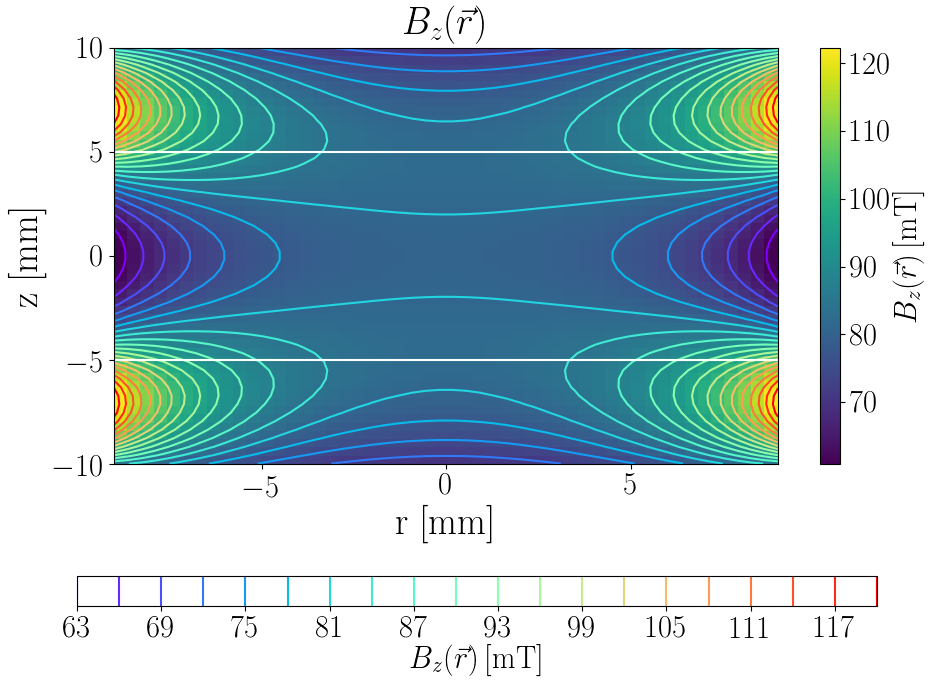

In [142]:
figBz, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_z(\vec{r})$', fontsize = labelsize)
ax.set_xlabel('r [mm]', fontsize = labelsize)
ax.set_ylabel('z [mm]', fontsize = labelsize)
ax.set_xlim(-0.9*R*10**3,0.9*R*10**3)
ax.set_ylim(-R*10**3,R*10**3)
ax.axhline(z0*10**3, color = 'white')
ax.axhline(-z0*10**3, color = 'white')
#ax.axes.set_aspect('equal')
cd = plt.pcolor(X2*10**3,Y2*10**3,B[0]*10**3, cmap=plt.get_cmap(cmaps.viridis))
C2 = plt.contour(X1*10**3, Y1*10**3, B[0]*10**3, 20, colors = cm.rainbow(np.linspace(0, 1, len(range(20)))))
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[mT]}$')

# make a colorbar for the contour lines
cbaxes = figBz.add_axes([0.1, -0.05, 0.8, 0.05])
CB = plt.colorbar(C2, orientation = 'horizontal', cax = cbaxes)
CB.set_label(r'$B_z(\vec{r})\,\mathrm{[mT]}$')


plt.tight_layout()

In [143]:
#figBz.savefig('Bzr35_35_con_R10_z5.png', dpi = 200)

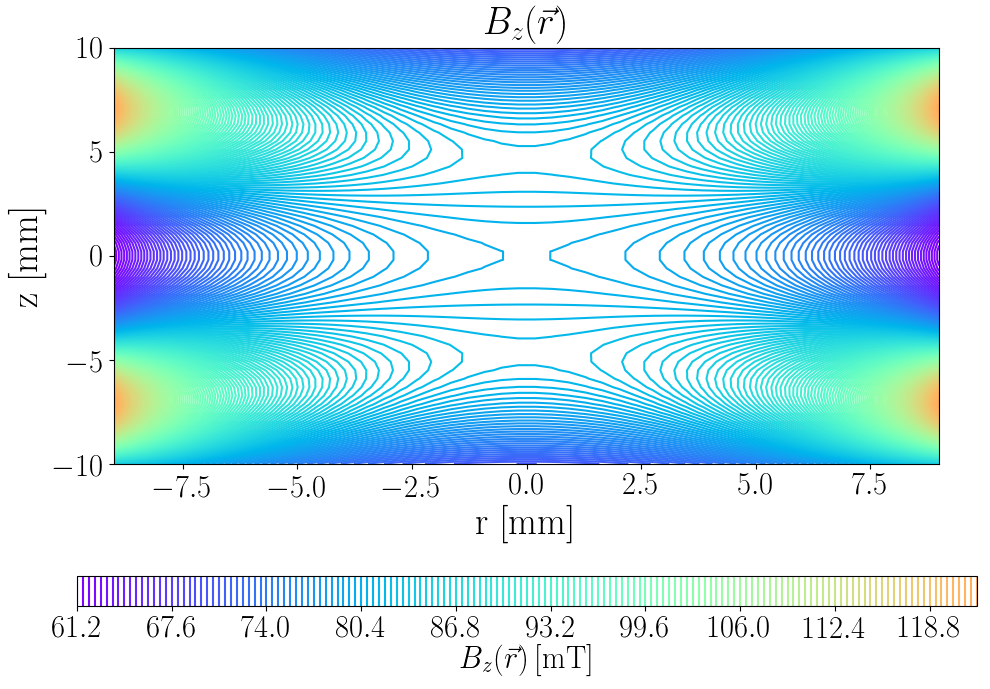

In [108]:
figBz2, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_z(\vec{r})$', fontsize = labelsize)
ax.set_xlabel('r [mm]', fontsize = labelsize)
ax.set_ylabel('z [mm]', fontsize = labelsize)
ax.set_xlim(-0.9*R*10**3,0.9*R*10**3)
ax.set_ylim(-R*10**3,R*10**3)
#ax.axhline(z0, color = 'white')
#ax.axhline(-z0, color = 'white')
#ax.axes.set_aspect('equal')
#cd = plt.pcolor(X2*10**3,Y2*10**3,B[0]*10**3, cmap=plt.get_cmap(cmaps.viridis))
C2 = plt.contour(X1*10**3, Y1*10**3, B[0]*10**3, 200, colors = cm.rainbow(np.linspace(0, 1, len(range(200)))))
#cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[mT]}$')

# make a colorbar for the contour lines
cbaxes = figBz2.add_axes([0.1, -0.05, 0.9, 0.05])
CB = plt.colorbar(C2, orientation = 'horizontal', cax = cbaxes)
CB.set_label(r'$B_z(\vec{r})\,\mathrm{[mT]}$')


plt.tight_layout()

In [109]:
#figBz2.savefig('Bzr35_35_con_only_R10_z5.png', dpi = 200)

index is out of bounds; max. value. N = 49


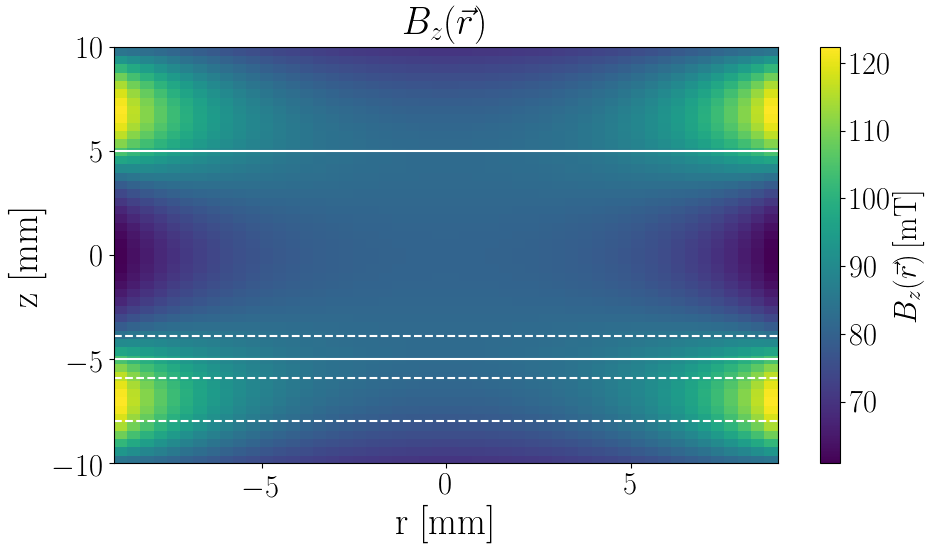

In [110]:
figBzz0, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_z(\vec{r})$', fontsize = labelsize)
ax.set_xlabel('r [mm]', fontsize = labelsize)
ax.set_ylabel('z [mm]', fontsize = labelsize)
ax.set_xlim(-0.9*R*10**3,0.9*R*10**3)
ax.set_ylim(-R*10**3,R*10**3)
#ax.set_ylim(-R,R)
ax.axhline(z0*10**3, color = 'white')
ax.axhline(-z0*10**3, color = 'white')
try:
    ax.axhline(z02[10]*10**3, color = 'white', ls = '--')
    ax.axhline(z02[5]*10**3, color = 'white', ls = '--')
    ax.axhline(z02[15]*10**3, color = 'white', ls = '--')
    ax.axhline(z02[50]*10**3, color = 'white', ls = '--')
    ax.axhline(z02[70]*10**3, color = 'white', ls = '--')
except:
    print 'index is out of bounds; max. value. N = {}'.format(len(r02)-1)
#ax.axes.set_aspect('equal')
cd = plt.pcolor(X2*10**3,Y2*10**3,B[0]*10**3, cmap=plt.get_cmap(cmaps.viridis))
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[mT]}$')
plt.tight_layout()

In [111]:
#figBzz0.savefig('Bzrz0_50_20.png', dpi = 200)

In [112]:
'''
figBzrz, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_z(r, z = z^{\prime})$', fontsize = labelsize)
ax.set_xlabel('r [mm]', fontsize = labelsize)
ax.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[mT]}$', fontsize = labelsize)
ax.axhline(z0, color = 'white', ls = '--')
#ax.axes.set_aspect('equal')
try:
    plt.plot(r02*10**3,B[0][5]*10**3, label = r'$z^\prime = {}\,\mathrm{{mm}}$'.format(truncate(z02[5]*10**3,2)))
    plt.plot(r02*10**3,B[0][10]*10**3,label = r'$z^\prime = {}\,\mathrm{{mm}}$'.format(truncate(z02[10]*10**3,2)))
    plt.plot(r02*10**3,B[0][15]*10**3, label = r'$z^\prime = {}\,\mathrm{{mm}}$'.format(truncate(z02[15]*10**3,2)))
    plt.plot(r02*10**3,B[0][30]*10**3, label = r'$z^\prime = {}\,\mathrm{{mm}}$'.format(truncate(z02[30]*10**3,2)))
    plt.plot(r02*10**3,B[0][45]*10**3, label = r'$z^\prime = {}\,\mathrm{{mm}}$'.format(truncate(z02[45]*10**3,2)))
except:
    print 'index is out of bounds; max. value. N = {}'.format(len(r02)-1)
plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.tight_layout()
'''

"\nfigBzrz, ax = plt.subplots(figsize =(10,6))\nax.set_title(r'$B_z(r, z = z^{\\prime})$', fontsize = labelsize)\nax.set_xlabel('r [mm]', fontsize = labelsize)\nax.set_ylabel(r'$B_z(\x0bec{r})\\,\\mathrm{[mT]}$', fontsize = labelsize)\nax.axhline(z0, color = 'white', ls = '--')\n#ax.axes.set_aspect('equal')\ntry:\n    plt.plot(r02*10**3,B[0][5]*10**3, label = r'$z^\\prime = {}\\,\\mathrm{{mm}}$'.format(truncate(z02[5]*10**3,2)))\n    plt.plot(r02*10**3,B[0][10]*10**3,label = r'$z^\\prime = {}\\,\\mathrm{{mm}}$'.format(truncate(z02[10]*10**3,2)))\n    plt.plot(r02*10**3,B[0][15]*10**3, label = r'$z^\\prime = {}\\,\\mathrm{{mm}}$'.format(truncate(z02[15]*10**3,2)))\n    plt.plot(r02*10**3,B[0][30]*10**3, label = r'$z^\\prime = {}\\,\\mathrm{{mm}}$'.format(truncate(z02[30]*10**3,2)))\n    plt.plot(r02*10**3,B[0][45]*10**3, label = r'$z^\\prime = {}\\,\\mathrm{{mm}}$'.format(truncate(z02[45]*10**3,2)))\nexcept:\n    print 'index is out of bounds; max. value. N = {}'.format(len(r02)-1)\nplt

In [113]:
#figBzrz.savefig('Bzrz100_10.png', dpi = 200)

In [114]:
'''
figBzz, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_z(r = r^\prime, z)$', fontsize = labelsize)
ax.set_xlabel('z [mm]', fontsize = labelsize)
ax.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[mT]}$', fontsize = labelsize)
ax.axhline(z0, color = 'white', ls = '--')
#ax.axes.set_aspect('equal')
try:
    plt.plot(z02*10**3,B[0][:,10]*10**3, label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r[10]*10**3,3)))
    plt.plot(z02*10**3,B[0][:,20]*10**3, label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r[20]*10**3,3)))
    plt.plot(z02*10**3,B[0][:,30]*10**3, label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r[50]*10**3,3)))
    plt.plot(z02*10**3,B[0][:,40]*10**3, label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r[70]*10**3,3)))
    plt.plot(z02*10**3,B[0][:,45]*10**3, label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r[80]*10**3,3)))
except:
    print 'index is out of bounds; max. value. N = {}'.format(len(z02)-1)    
plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.tight_layout()
'''

"\nfigBzz, ax = plt.subplots(figsize =(10,6))\nax.set_title(r'$B_z(r = r^\\prime, z)$', fontsize = labelsize)\nax.set_xlabel('z [mm]', fontsize = labelsize)\nax.set_ylabel(r'$B_z(\x0bec{r})\\,\\mathrm{[mT]}$', fontsize = labelsize)\nax.axhline(z0, color = 'white', ls = '--')\n#ax.axes.set_aspect('equal')\ntry:\n    plt.plot(z02*10**3,B[0][:,10]*10**3, label = r'$r^\\prime = {}\\mathrm{{mm}}$'.format(truncate(r[10]*10**3,3)))\n    plt.plot(z02*10**3,B[0][:,20]*10**3, label = r'$r^\\prime = {}\\mathrm{{mm}}$'.format(truncate(r[20]*10**3,3)))\n    plt.plot(z02*10**3,B[0][:,30]*10**3, label = r'$r^\\prime = {}\\mathrm{{mm}}$'.format(truncate(r[50]*10**3,3)))\n    plt.plot(z02*10**3,B[0][:,40]*10**3, label = r'$r^\\prime = {}\\mathrm{{mm}}$'.format(truncate(r[70]*10**3,3)))\n    plt.plot(z02*10**3,B[0][:,45]*10**3, label = r'$r^\\prime = {}\\mathrm{{mm}}$'.format(truncate(r[80]*10**3,3)))\nexcept:\n    print 'index is out of bounds; max. value. N = {}'.format(len(z02)-1)    \nplt.legend(loc

In [115]:
#figBzz.savefig('Bzz100_10.png', dpi = 200)

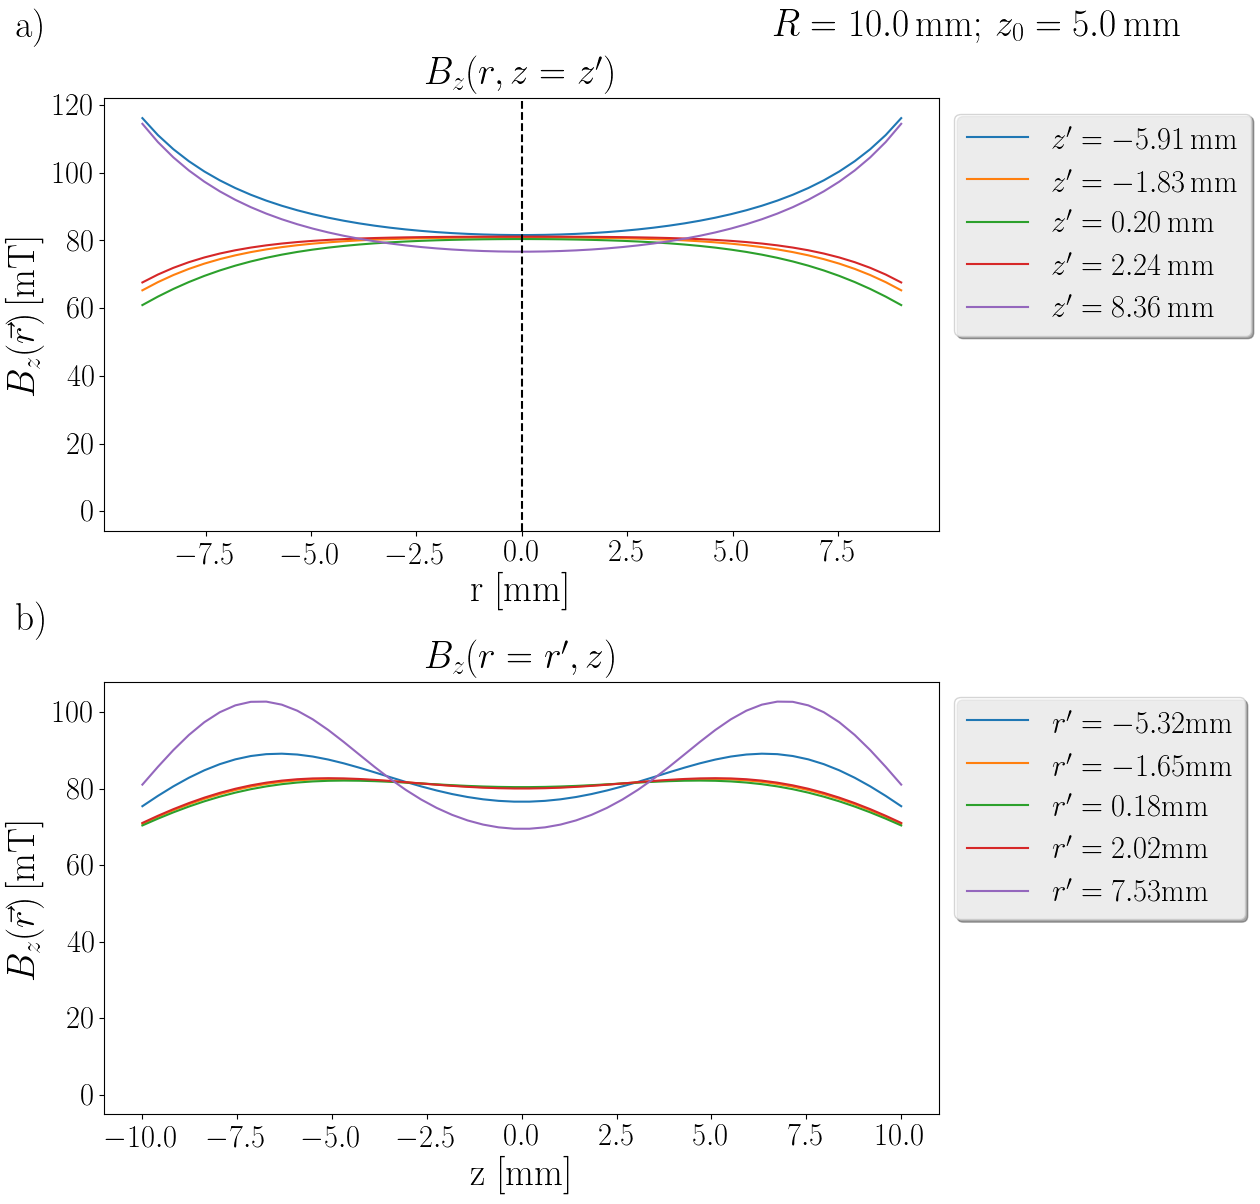

In [149]:
fig_Bz = plt.figure(figsize = (10,12))

figlabel = fig_Bz.suptitle(r'$R = {}\,\mathrm{{mm}};\,z_0 = {}\,\mathrm{{mm}}$'.format(R*10**3, z0*10**3),  fontsize = labelsize)
figlabel.set_position([1.0,1.01])

fig00r = plt.subplot(211)
#fig00r.text(-8,75, 'a)', fontsize = labelsize )
fig00r.text(-R*10**3-2,140, 'a)', fontsize = labelsize )
fig00r.text(-R*10**3-2,-35, 'b)', fontsize = labelsize )
fig00r.set_title(r'$B_z(r, z = z^{\prime})$', fontsize = labelsize)
fig00r.set_xlabel('r [mm]', fontsize = labelsize)
fig00r.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[mT]}$', fontsize = labelsize)
fig00r.axhline(z0, color = 'white', ls = '--')
#ax.axes.set_aspect('equal')
try:
    plt.plot(r02*10**3,B[0][10]*10**3, label = r'$z^\prime = {}\,\mathrm{{mm}}$'.format(truncate(z02[10]*10**3,2)))
    plt.plot(r02*10**3,B[0][20]*10**3,label = r'$z^\prime = {}\,\mathrm{{mm}}$'.format(truncate(z02[20]*10**3,2)))
    plt.plot(r02*10**3,B[0][25]*10**3, label = r'$z^\prime = {}\,\mathrm{{mm}}$'.format(truncate(z02[25]*10**3,2)))
    plt.plot(r02*10**3,B[0][30]*10**3, label = r'$z^\prime = {}\,\mathrm{{mm}}$'.format(truncate(z02[30]*10**3,2)))
    plt.plot(r02*10**3,B[0][45]*10**3, label = r'$z^\prime = {}\,\mathrm{{mm}}$'.format(truncate(z02[45]*10**3,2)))
except:
    print 'index is out of bounds; max. value. N = {}'.format(len(z02)-1)    
#fig00r.set_yticks([-40,-20,0,20,40])
#plt.axhline(0, color = 'black', ls = '--')
plt.axvline(0, color = 'black', ls = '--')

plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.tight_layout()

fig01r = plt.subplot(212)
fig01r.set_title(r'$B_z(r = r^\prime, z)$', fontsize = labelsize)
fig01r.set_xlabel('z [mm]', fontsize = labelsize)
fig01r.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[mT]}$', fontsize = labelsize)
fig01r.axhline(z0, color = 'white', ls = '--')
#fig01r.set_xticks([])
#ax.axes.set_aspect('equal')
try:
    plt.plot(z02*10**3,B[0][:,10]*10**3, label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r02[10]*10**3,2)))
    plt.plot(z02*10**3,B[0][:,20]*10**3, label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r02[20]*10**3,2)))
    plt.plot(z02*10**3,B[0][:,25]*10**3, label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r02[25]*10**3,2)))
    plt.plot(z02*10**3,B[0][:,30]*10**3, label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r02[30]*10**3,2)))
    plt.plot(z02*10**3,B[0][:,45]*10**3, label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r02[45]*10**3,2)))
except:
    print 'index is out of bounds; max. value. N = {}'.format(len(z02)-1)    
#fig01r.set_yticks([-20,-10,0,10,20])
#fig01r.set_ylim(-25,25)
#fig01r.text(-2*z0*10**3-2,120, 'b)', fontsize = labelsize )
#fig01r.text(-8,75, 'b)', fontsize = labelsize )
plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.tight_layout()

plt.show()

In [150]:
#fig_Bz.savefig('Bz35_35_con_R10_z5.png', dpi = 200)

### radial component:

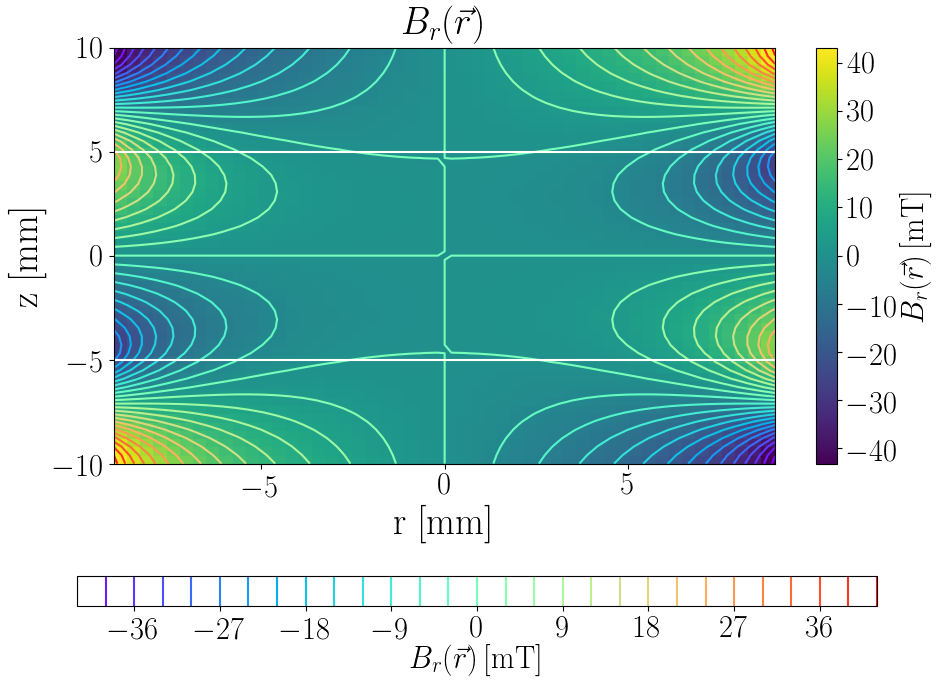

In [157]:
figBrr, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_r(\vec{r})$', fontsize = labelsize)
ax.set_xlabel('r [mm]', fontsize = labelsize)
ax.set_ylabel('z [mm]', fontsize = labelsize)
ax.set_xlim(-0.9*R*10**3,0.9*R*10**3)
ax.set_ylim(-R*10**3,R*10**3)
ax.axhline(z0*10**3, color = 'white')
ax.axhline(-z0*10**3, color = 'white')
#ax.axes.set_aspect('equal')
#C2 = plt.contour(X1*10**3, Y1*10**3, B[1]*10**3,30)
cd = plt.pcolor(X2*10**3,Y2*10**3,B[1]*10**3, cmap=plt.get_cmap(cmaps.viridis))
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_r(\vec{r})\,\mathrm{[mT]}$')

C2 = plt.contour(X1*10**3, Y1*10**3, B[1]*10**3, 30, colors = cm.rainbow(np.linspace(0, 1, len(range(30)))))

# make a colorbar for the contour lines
cbaxes = figBrr.add_axes([0.1, -0.05, 0.8, 0.05])
CB = plt.colorbar(C2, orientation = 'horizontal', cax = cbaxes)
CB.set_label(r'$B_r(\vec{r})\,\mathrm{[mT]}$')

plt.tight_layout()

In [158]:
#figBrr.savefig('Brr35_35_R10_z5_con.png', dpi = 200)

In [120]:
'''
figBrrz, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_r(r, z = z^{{\prime}});\,R = {}\,\mathrm{{mm}};\,z_0 = {}\,\mathrm{{mm}}$'.format(R*10**3, z0*10**3), fontsize = labelsize)
ax.set_xlabel('r [mm]', fontsize = labelsize)
ax.set_ylabel(r'$B_r(\vec{{r}})\,\mathrm{{[mT]}}$', fontsize = labelsize)
ax.axhline(z0, color = 'white', ls = '--')
#ax.axes.set_aspect('equal')
try:
    plt.plot(r02*10**3,B[1][5]*10**3, label = r'$z^\prime = {}$'.format(truncate(z02[5],4)))
    plt.plot(r02*10**3,B[1][10]*10**3,label = r'$z^\prime = {}$'.format(truncate(z02[10],4)))
    plt.plot(r02*10**3,B[1][15]*10**3, label = r'$z^\prime = {}$'.format(truncate(z02[15],4)))
    plt.plot(r02*10**3,B[1][35]*10**3, label = r'$z^\prime = {}$'.format(truncate(z02[35],4)))
    plt.plot(r02*10**3,B[1][45]*10**3, label = r'$z^\prime = {}$'.format(truncate(z02[45],4)))
except:
    print 'index is out of bounds; max. value. N = {}'.format(len(z02)-1)    
plt.axhline(0, color = 'black', ls = '--')
plt.axvline(0, color = 'black', ls = '--')
plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.tight_layout()

'''

"\nfigBrrz, ax = plt.subplots(figsize =(10,6))\nax.set_title(r'$B_r(r, z = z^{{\\prime}});\\,R = {}\\,\\mathrm{{mm}};\\,z_0 = {}\\,\\mathrm{{mm}}$'.format(R*10**3, z0*10**3), fontsize = labelsize)\nax.set_xlabel('r [mm]', fontsize = labelsize)\nax.set_ylabel(r'$B_r(\x0bec{{r}})\\,\\mathrm{{[mT]}}$', fontsize = labelsize)\nax.axhline(z0, color = 'white', ls = '--')\n#ax.axes.set_aspect('equal')\ntry:\n    plt.plot(r02*10**3,B[1][5]*10**3, label = r'$z^\\prime = {}$'.format(truncate(z02[5],4)))\n    plt.plot(r02*10**3,B[1][10]*10**3,label = r'$z^\\prime = {}$'.format(truncate(z02[10],4)))\n    plt.plot(r02*10**3,B[1][15]*10**3, label = r'$z^\\prime = {}$'.format(truncate(z02[15],4)))\n    plt.plot(r02*10**3,B[1][35]*10**3, label = r'$z^\\prime = {}$'.format(truncate(z02[35],4)))\n    plt.plot(r02*10**3,B[1][45]*10**3, label = r'$z^\\prime = {}$'.format(truncate(z02[45],4)))\nexcept:\n    print 'index is out of bounds; max. value. N = {}'.format(len(z02)-1)    \nplt.axhline(0, color = 'bl

In [121]:
#figBrrz.savefig('Brrz100_10.png', dpi = 200)

In [122]:
'''
figBrrr, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_r(r = r^\prime, z)$', fontsize = labelsize)
ax.set_xlabel('z [mm]', fontsize = labelsize)
ax.set_ylabel(r'$B_r(\vec{r})\,\mathrm{[T]}$', fontsize = labelsize)
ax.axhline(z0, color = 'white', ls = '--')
#ax.axes.set_aspect('equal')
try:
    plt.plot(z02*10**3,B[1][:,10], label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r[10]*10**3,3)))
    plt.plot(z02*10**3,B[1][:,20], label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r[20]*10**3,3)))
    plt.plot(z02*10**3,B[1][:,30], label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r[50]*10**3,3)))
    plt.plot(z02*10**3,B[1][:,40], label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r[70]*10**3,3)))
    plt.plot(z02*10**3,B[1][:,45], label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r[80]*10**3,3)))
except:
    print 'index is out of bounds; max. value. N = {}'.format(len(z02)-1)    
plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.tight_layout()
'''

"\nfigBrrr, ax = plt.subplots(figsize =(10,6))\nax.set_title(r'$B_r(r = r^\\prime, z)$', fontsize = labelsize)\nax.set_xlabel('z [mm]', fontsize = labelsize)\nax.set_ylabel(r'$B_r(\x0bec{r})\\,\\mathrm{[T]}$', fontsize = labelsize)\nax.axhline(z0, color = 'white', ls = '--')\n#ax.axes.set_aspect('equal')\ntry:\n    plt.plot(z02*10**3,B[1][:,10], label = r'$r^\\prime = {}\\mathrm{{mm}}$'.format(truncate(r[10]*10**3,3)))\n    plt.plot(z02*10**3,B[1][:,20], label = r'$r^\\prime = {}\\mathrm{{mm}}$'.format(truncate(r[20]*10**3,3)))\n    plt.plot(z02*10**3,B[1][:,30], label = r'$r^\\prime = {}\\mathrm{{mm}}$'.format(truncate(r[50]*10**3,3)))\n    plt.plot(z02*10**3,B[1][:,40], label = r'$r^\\prime = {}\\mathrm{{mm}}$'.format(truncate(r[70]*10**3,3)))\n    plt.plot(z02*10**3,B[1][:,45], label = r'$r^\\prime = {}\\mathrm{{mm}}$'.format(truncate(r[80]*10**3,3)))\nexcept:\n    print 'index is out of bounds; max. value. N = {}'.format(len(z02)-1)    \nplt.legend(loc = 'upper left', bbox_to_ancho

In [123]:
#figBrrr.savefig('Brrr.png', dpi = 200)

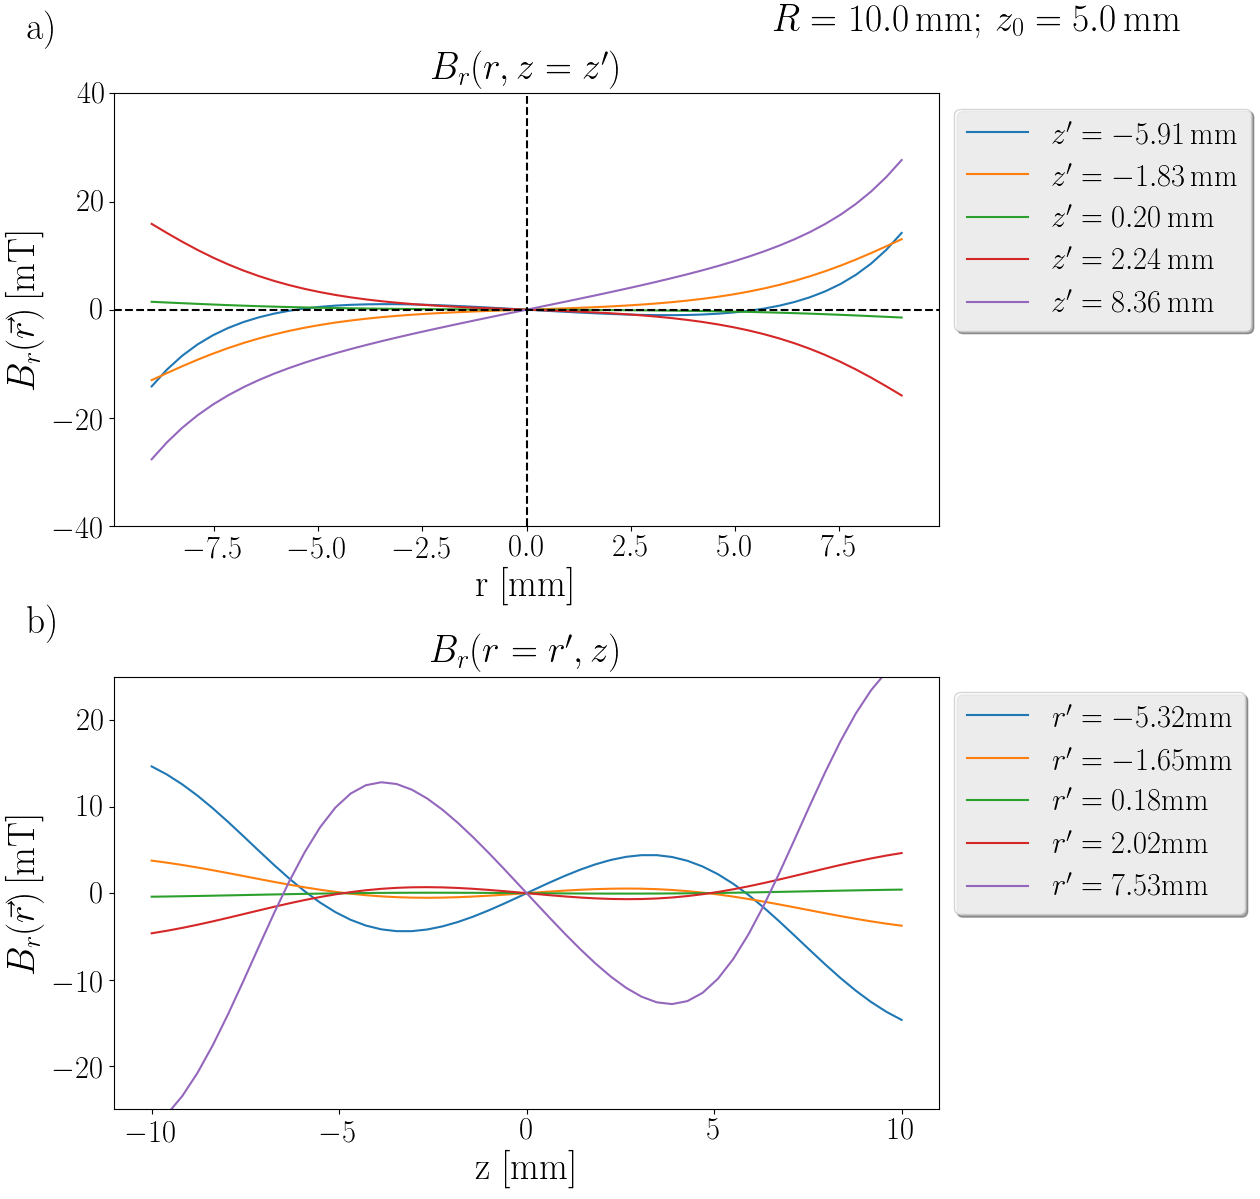

In [160]:
fig_Br = plt.figure(figsize = (10,12))

figlabel = fig_Br.suptitle(r'$R = {}\,\mathrm{{mm}};\,z_0 = {}\,\mathrm{{mm}}$'.format(R*10**3, z0*10**3),  fontsize = labelsize)
figlabel.set_position([1.0,1.01])

fig00r = plt.subplot(211)
fig00r.text(-R*10**3-2,50, 'a)', fontsize = labelsize )
fig00r.text(-R*10**3-2,-60, 'b)', fontsize = labelsize )
fig00r.set_title(r'$B_r(r, z = z^{\prime})$', fontsize = labelsize)
fig00r.set_xlabel('r [mm]', fontsize = labelsize)
fig00r.set_ylabel(r'$B_r(\vec{r})\,\mathrm{[mT]}$', fontsize = labelsize)
fig00r.axhline(z0, color = 'white', ls = '--')
#ax.axes.set_aspect('equal')
plt.plot(r02*10**3,B[1][10]*10**3, label = r'$z^\prime = {}\,\mathrm{{mm}}$'.format(truncate(z02[10]*10**3,2)))
plt.plot(r02*10**3,B[1][20]*10**3,label = r'$z^\prime = {}\,\mathrm{{mm}}$'.format(truncate(z02[20]*10**3,2)))
plt.plot(r02*10**3,B[1][25]*10**3, label = r'$z^\prime = {}\,\mathrm{{mm}}$'.format(truncate(z02[25]*10**3,2)))
try:
    plt.plot(r02*10**3,B[1][30]*10**3, label = r'$z^\prime = {}\,\mathrm{{mm}}$'.format(truncate(z02[30]*10**3,2)))
    plt.plot(r02*10**3,B[1][45]*10**3, label = r'$z^\prime = {}\,\mathrm{{mm}}$'.format(truncate(z02[45]*10**3,2)))
except:
    print 'index is out of bounds; max. value. N = {}'.format(len(z02)-1)    
fig00r.set_yticks([-40,-20,0,20,40])
plt.axhline(0, color = 'black', ls = '--')
plt.axvline(0, color = 'black', ls = '--')

plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.tight_layout()

fig01r = plt.subplot(212)
fig01r.set_title(r'$B_r(r = r^\prime, z)$', fontsize = labelsize)
fig01r.set_xlabel('z [mm]', fontsize = labelsize)
fig01r.set_ylabel(r'$B_r(\vec{r})\,\mathrm{[mT]}$', fontsize = labelsize)
fig01r.axhline(z0, color = 'white', ls = '--')
#fig01r.set_xticks([])
#ax.axes.set_aspect('equal')
plt.plot(z02*10**3,B[1][:,10]*10**3, label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r02[10]*10**3,2)))
plt.plot(z02*10**3,B[1][:,20]*10**3, label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r02[20]*10**3,2)))
try:
    plt.plot(z02*10**3,B[1][:,25]*10**3, label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r02[25]*10**3,2)))
    plt.plot(z02*10**3,B[1][:,30]*10**3, label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r02[30]*10**3,2)))
    plt.plot(z02*10**3,B[1][:,45]*10**3, label = r'$r^\prime = {}\mathrm{{mm}}$'.format(truncate(r02[45]*10**3,2)))
except:
    print 'index is out of bounds; max. value. N = {}'.format(len(z02)-1)    
fig01r.set_yticks([-20,-10,0,10,20])
fig01r.set_ylim(-25,25)
plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.tight_layout()

plt.show()

In [161]:
#fig_Br.savefig('Br35_35_R10_z5.png', dpi = 200, bbox_to_anchor = 'tight')

### Magnitude

In [126]:
B_mag = np.array(np.sqrt(B[0]**2.+B[1]**2))

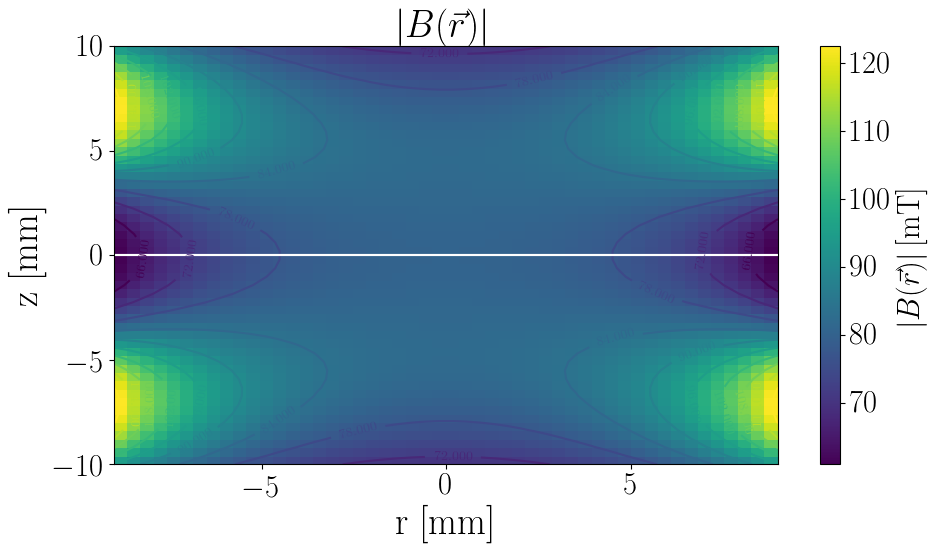

In [127]:
figBmag, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$|B(\vec{r})|$', fontsize = labelsize)
ax.set_xlabel('r [mm]', fontsize = labelsize)
ax.set_ylabel('z [mm]', fontsize = labelsize)
ax.set_xlim(-0.9*R*10**3,0.9*R*10**3)
ax.set_ylim(-R*10**3,R*10**3)
ax.axhline(z0, color = 'white')
ax.axhline(-z0, color = 'white')
#ax.axes.set_aspect('equal')
levels = [45,47,48, 50]
CS = plt.contour(X1*10**3, Y1*10**3, B_mag*10**3,10)
cd = plt.pcolor(X2*10**3,Y2*10**3,(B_mag)*10**3, cmap=plt.get_cmap(cmaps.viridis))
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$|B(\vec{r})|\,\mathrm{[mT]}$')
plt.clabel(CS, inline=1, fontsize=10)
plt.tight_layout()

In [128]:
#figBmag.savefig('Bmag50_20.png', dpi = 200)

### Multiplot for different arrangements

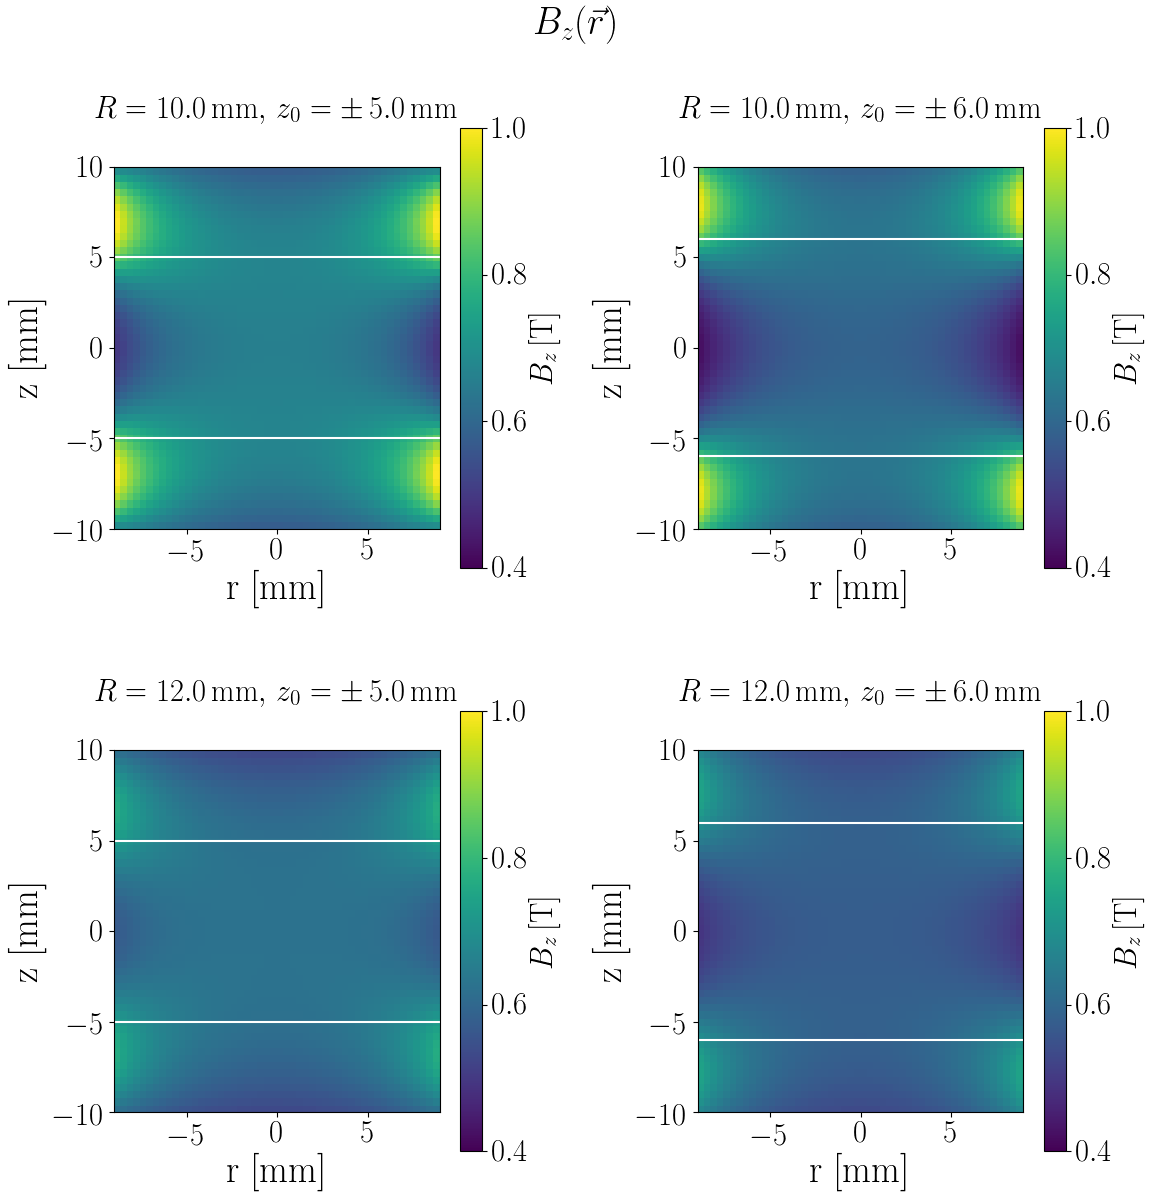

In [129]:
fig = plt.figure(figsize =(12,12))


figlabel = fig.suptitle(r'$B_z(\vec{{r}})$',  fontsize = labelsize)
figlabel.set_position([0.5,1.03])
fig1 = plt.subplot(221)
fig1.set_aspect('equal')
fig1title = fig1.set_title(r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z0*10**3), fontsize = int(labelsize-5))
fig1title.set_position([0.5,1.1])
fig1.set_xlabel('r [mm]', fontsize = labelsize)
fig1.set_ylabel('z [mm]', fontsize = labelsize)
fig1.set_xlim(-0.9*R*10**3,0.9*R*10**3)
fig1.set_ylim(-R*10**3,R*10**3)
fig1.axhline(z0*10**3, color = 'white')
fig1.axhline(-z0*10**3, color = 'white')
cd = plt.pcolormesh(X2*10**3,Y2*10**3,B[0]/np.max(B[0]), cmap=plt.get_cmap(cmaps.viridis), vmin = 0.4, vmax = 1.0)
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_z\,\mathrm{[T]}$')
cbar.set_ticks([0.4,0.6,0.8,1.0])

#fig1.text(-10,10, 'a)', fontsize = labelsize )



z0_prime = z0+0.001

fig2 = plt.subplot(222)
fig2.set_aspect('equal')
fig2title = fig2.set_title(r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z0_prime*10**3), fontsize = int(labelsize-5))
fig2title.set_position([0.5,1.1])
fig2.set_xlabel('r [mm]', fontsize = labelsize)
fig2.set_ylabel('z [mm]', fontsize = labelsize)
fig2.set_xlim(-0.9*R*10**3,0.9*R*10**3)
fig2.set_ylim(-R*10**3,R*10**3)
fig2.axhline(z0_prime*10**3, color = 'white')
fig2.axhline(-z0_prime*10**3, color = 'white')
cd = plt.pcolormesh(X2*10**3,Y2*10**3,Bwgh[0]/np.max(B[0]), cmap=plt.get_cmap(cmaps.viridis), vmin = 0.4, vmax = 1.0)
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_z\,\mathrm{[T]}$')
cbar.set_ticks([0.4,0.6,0.8,1.0])

#fig2.text(-10,10, 'b)', fontsize = labelsize )


R_prime = R+0.002

fig3 = plt.subplot(223)
fig3.set_aspect('equal')
fig3title = fig3.set_title(r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z0*10**3), fontsize = int(labelsize-5))
fig3title.set_position([0.5,1.1])
fig3.set_xlabel('r [mm]', fontsize = labelsize)
fig3.set_ylabel('z [mm]', fontsize = labelsize)
fig3.set_xlim(-0.9*R*10**3,0.9*R*10**3)
fig3.set_ylim(-R*10**3,R*10**3)
fig3.axhline(z0*10**3, color = 'white')
fig3.axhline(-z0*10**3, color = 'white')
cd = plt.pcolormesh(X2*10**3,Y2*10**3,BR2[0]/np.max(B[0]), cmap=plt.get_cmap(cmaps.viridis), vmin = 0.4, vmax = 1.0)
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_z\,\mathrm{[T]}$')
cbar.set_ticks([0.4,0.6,0.8,1.0])


#fig3.text(-10,10, 'c)', fontsize = labelsize )



fig4 = plt.subplot(224)
fig4.set_aspect('equal')
fig4title = fig4.set_title(r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z0_prime*10**3), fontsize = int(labelsize-5))
fig4title.set_position([0.5,1.1])
fig4.set_xlabel('r [mm]', fontsize = labelsize)
fig4.set_ylabel('z [mm]', fontsize = labelsize)
fig4.set_xlim(-0.9*R*10**3,0.9*R*10**3)
fig4.set_ylim(-R*10**3,R*10**3)
fig4.axhline(z0_prime*10**3, color = 'white')
fig4.axhline(-z0_prime*10**3, color = 'white')
cd = plt.pcolormesh(X2*10**3,Y2*10**3,Bwgh2[0]/np.max(B[0]), cmap=plt.get_cmap(cmaps.viridis), vmin = 0.4, vmax = 1.0)
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_z\,\mathrm{[T]}$')
cbar.set_ticks([0.4,0.6,0.8,1.0])

#fig4.text(-10,10, 'd)', fontsize = labelsize )

plt.tight_layout()

In [130]:
#fig.savefig('Bz_comparison_50_20.png', dpi = 200)

In [131]:
numb = int(len(z02)/2.)

'''
fig01, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_z(r, z = {}\,\mathrm{{mm}})$'.format(truncate(z02[numb]*10**3,2)), fontsize = labelsize)
ax.set_xlabel('r [mm]', fontsize = labelsize)
ax.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[T]}$', fontsize = labelsize)
ax.axhline(z0, color = 'white', ls = '--')
#ax.axes.set_aspect('equal')
plt.plot(r02*10**3,B[0][numb], label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z0*10**3))
plt.plot(r02*10**3,Bwgh[0][numb],label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z0_prime*10**3))
plt.plot(r02*10**3,Bwgh2[0][numb], label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z0_prime*10**3))
plt.plot(r02*10**3,BR2[0][numb], label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z0*10**3))

plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.tight_layout()
'''

"\nfig01, ax = plt.subplots(figsize =(10,6))\nax.set_title(r'$B_z(r, z = {}\\,\\mathrm{{mm}})$'.format(truncate(z02[numb]*10**3,2)), fontsize = labelsize)\nax.set_xlabel('r [mm]', fontsize = labelsize)\nax.set_ylabel(r'$B_z(\x0bec{r})\\,\\mathrm{[T]}$', fontsize = labelsize)\nax.axhline(z0, color = 'white', ls = '--')\n#ax.axes.set_aspect('equal')\nplt.plot(r02*10**3,B[0][numb], label = r'$R = {}\\,\\mathrm{{mm}},\\,z_0 = \\pm\\,{}\\,\\mathrm{{mm}} $'.format(R*10**3, z0*10**3))\nplt.plot(r02*10**3,Bwgh[0][numb],label = r'$R = {}\\,\\mathrm{{mm}},\\,z_0 = \\pm\\,{}\\,\\mathrm{{mm}} $'.format(R*10**3, z0_prime*10**3))\nplt.plot(r02*10**3,Bwgh2[0][numb], label = r'$R = {}\\,\\mathrm{{mm}},\\,z_0 = \\pm\\,{}\\,\\mathrm{{mm}} $'.format(R_prime*10**3, z0_prime*10**3))\nplt.plot(r02*10**3,BR2[0][numb], label = r'$R = {}\\,\\mathrm{{mm}},\\,z_0 = \\pm\\,{}\\,\\mathrm{{mm}} $'.format(R_prime*10**3, z0*10**3))\n\nplt.legend(loc = 'upper left', bbox_to_anchor = (1,1))\nplt.tight_layout()\n"

In [132]:
#fig01.savefig('Bz_100_10_comp.png', dpi = 200)

In [133]:
numb = int(len(z02)/2.)
'''
fig02, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_z(r = 0, z)$', fontsize = labelsize)
ax.set_xlabel('z [mm]', fontsize = labelsize)
ax.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[T]}$', fontsize = labelsize)
ax.axhline(z0, color = 'white', ls = '--')
#ax.axes.set_aspect('equal')
plt.plot(z02*10**3,B[0][:,numb], label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z0*10**3))
plt.plot(z02*10**3,Bwgh[0][:,numb],label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z0_prime*10**3))
plt.plot(z02*10**3,Bwgh2[0][:,numb], label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z0_prime*10**3))
plt.plot(z02*10**3,BR2[0][:,numb], label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z0*10**3))

plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.tight_layout()
'''

"\nfig02, ax = plt.subplots(figsize =(10,6))\nax.set_title(r'$B_z(r = 0, z)$', fontsize = labelsize)\nax.set_xlabel('z [mm]', fontsize = labelsize)\nax.set_ylabel(r'$B_z(\x0bec{r})\\,\\mathrm{[T]}$', fontsize = labelsize)\nax.axhline(z0, color = 'white', ls = '--')\n#ax.axes.set_aspect('equal')\nplt.plot(z02*10**3,B[0][:,numb], label = r'$R = {}\\,\\mathrm{{mm}},\\,z_0 = \\pm\\,{}\\,\\mathrm{{mm}} $'.format(R*10**3, z0*10**3))\nplt.plot(z02*10**3,Bwgh[0][:,numb],label = r'$R = {}\\,\\mathrm{{mm}},\\,z_0 = \\pm\\,{}\\,\\mathrm{{mm}} $'.format(R*10**3, z0_prime*10**3))\nplt.plot(z02*10**3,Bwgh2[0][:,numb], label = r'$R = {}\\,\\mathrm{{mm}},\\,z_0 = \\pm\\,{}\\,\\mathrm{{mm}} $'.format(R_prime*10**3, z0_prime*10**3))\nplt.plot(z02*10**3,BR2[0][:,numb], label = r'$R = {}\\,\\mathrm{{mm}},\\,z_0 = \\pm\\,{}\\,\\mathrm{{mm}} $'.format(R_prime*10**3, z0*10**3))\n\nplt.legend(loc = 'upper left', bbox_to_anchor = (1,1))\nplt.tight_layout()\n"

In [134]:
#fig02.savefig('Bzr0_100_10_comp.png', dpi = 200)

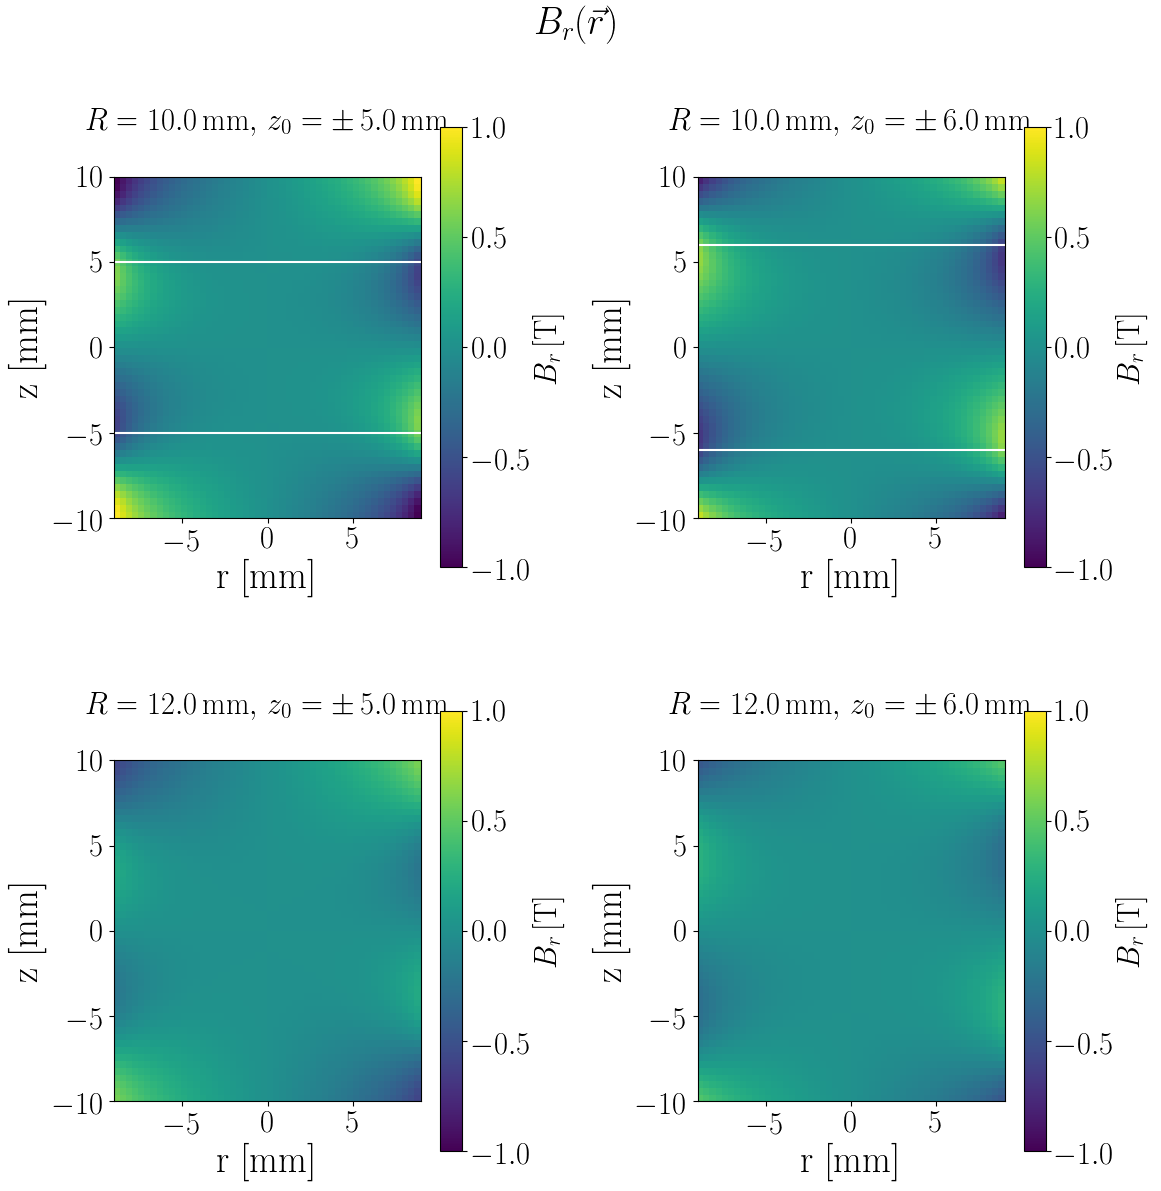

In [135]:
fig = plt.figure(figsize =(12,12))


figlabel = fig.suptitle(r'$B_r(\vec{{r}})$',  fontsize = labelsize)
figlabel.set_position([0.5,1.03])


fig1 = plt.subplot(221)
fig1.set_aspect('equal')
fig1title = fig1.set_title(r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z0*10**3), fontsize = int(labelsize-5))
fig1title.set_position([0.5,1.1])
fig1.set_xlabel('r [mm]', fontsize = labelsize)
fig1.set_ylabel('z [mm]', fontsize = labelsize)
fig1.set_xlim(-0.9*R*10**3,0.9*R*10**3)
fig1.set_ylim(-R*10**3,R*10**3)
fig1.axhline(z0*10**3, color = 'white')
fig1.axhline(-z0*10**3, color = 'white')
cd = plt.pcolormesh(X2*10**3,Y2*10**3,B[1]/np.max(B[1]), cmap=plt.get_cmap(cmaps.viridis), vmin = -1.0, vmax = 1.0)
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_r\,\mathrm{[T]}$')
cbar.set_ticks([-1.0,-0.5,0, 0.5,1.0])




z0_prime = z0+0.001

fig2 = plt.subplot(222)
fig2.set_aspect('equal')
fig2title = fig2.set_title(r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z0_prime*10**3), fontsize = int(labelsize-5))
fig2title.set_position([0.5,1.1])
fig2.set_xlabel('r [mm]', fontsize = labelsize)
fig2.set_ylabel('z [mm]', fontsize = labelsize)
fig2.set_xlim(-0.9*R*10**3,0.9*R*10**3)
fig2.set_ylim(-R*10**3,R*10**3)
fig2.axhline(z0_prime*10**3, color = 'white')
fig2.axhline(-z0_prime*10**3, color = 'white')
cd = plt.pcolormesh(X2*10**3,Y2*10**3,Bwgh[1]/np.max(B[1]), cmap=plt.get_cmap(cmaps.viridis), vmin = -1.0, vmax = 1.0)
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_r\,\mathrm{[T]}$')
cbar.set_ticks([-1.0,-0.5,0, 0.5,1.0])


R_prime = R+0.002

fig3 = plt.subplot(223)
fig3.set_aspect('equal')
fig3title = fig3.set_title(r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z0*10**3), fontsize = int(labelsize-5))
fig3title.set_position([0.5,1.1])
fig3.set_xlabel('r [mm]', fontsize = labelsize)
fig3.set_ylabel('z [mm]', fontsize = labelsize)
fig3.set_xlim(-0.9*R*10**3,0.9*R*10**3)
fig3.set_ylim(-R*10**3,R*10**3)
cd = plt.pcolormesh(X2*10**3,Y2*10**3,BR2[1]/np.max(B[1]), cmap=plt.get_cmap(cmaps.viridis), vmin = -1.0, vmax = 1.0)
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_r\,\mathrm{[T]}$')
cbar.set_ticks([-1.0,-0.5,0, 0.5,1.0])

fig4 = plt.subplot(224)
fig4.set_aspect('equal')
fig4title = fig4.set_title(r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z0_prime*10**3), fontsize = int(labelsize-5))
fig4title.set_position([0.5,1.1])
fig4.set_xlabel('r [mm]', fontsize = labelsize)
fig4.set_ylabel('z [mm]', fontsize = labelsize)
fig4.set_xlim(-0.9*R*10**3,0.9*R*10**3)
fig4.set_ylim(-R*10**3,R*10**3)
cd = plt.pcolormesh(X2*10**3,Y2*10**3,Bwgh2[1]/np.max(B[1]), cmap=plt.get_cmap(cmaps.viridis), vmin = -1.0, vmax = 1.0)
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_r\,\mathrm{[T]}$')
cbar.set_ticks([-1.0,-0.5,0, 0.5,1.0])


#fig1.text(-10,10, 'a)', fontsize = labelsize )
#fig2.text(-10,10, 'b)', fontsize = labelsize )
#fig3.text(-10,10, 'c)', fontsize = labelsize )
#fig4.text(-10,10, 'd)', fontsize = labelsize )

plt.tight_layout()

In [136]:
#fig.savefig('Br_comparison50_20.png', dpi = 200)

In [137]:
numb = int(len(z02)/2.)
'''
fig03, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_r(r, z = 0)$', fontsize = labelsize)
ax.set_xlabel('r [mm]', fontsize = labelsize)
ax.set_ylabel(r'$B_r(\vec{r})\,\mathrm{[T]}$', fontsize = labelsize)
#ax.axes.set_aspect('equal')
plt.axhline(0, color = 'black', ls = '--')
plt.axvline(0, color = 'black', ls = '--')
plt.plot(r02*10**3,B[1][numb]*10**3, label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z0*10**3))
plt.plot(r02*10**3,Bwgh[1][numb]*10**3,label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z0_prime*10**3))
plt.plot(r02*10**3,Bwgh2[1][numb]*10**3, label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z0_prime*10**3))
plt.plot(r02*10**3,BR2[1][numb]*10**3, label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z0*10**3))

plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.tight_layout()

'''

"\nfig03, ax = plt.subplots(figsize =(10,6))\nax.set_title(r'$B_r(r, z = 0)$', fontsize = labelsize)\nax.set_xlabel('r [mm]', fontsize = labelsize)\nax.set_ylabel(r'$B_r(\x0bec{r})\\,\\mathrm{[T]}$', fontsize = labelsize)\n#ax.axes.set_aspect('equal')\nplt.axhline(0, color = 'black', ls = '--')\nplt.axvline(0, color = 'black', ls = '--')\nplt.plot(r02*10**3,B[1][numb]*10**3, label = r'$R = {}\\,\\mathrm{{mm}},\\,z_0 = \\pm\\,{}\\,\\mathrm{{mm}} $'.format(R*10**3, z0*10**3))\nplt.plot(r02*10**3,Bwgh[1][numb]*10**3,label = r'$R = {}\\,\\mathrm{{mm}},\\,z_0 = \\pm\\,{}\\,\\mathrm{{mm}} $'.format(R*10**3, z0_prime*10**3))\nplt.plot(r02*10**3,Bwgh2[1][numb]*10**3, label = r'$R = {}\\,\\mathrm{{mm}},\\,z_0 = \\pm\\,{}\\,\\mathrm{{mm}} $'.format(R_prime*10**3, z0_prime*10**3))\nplt.plot(r02*10**3,BR2[1][numb]*10**3, label = r'$R = {}\\,\\mathrm{{mm}},\\,z_0 = \\pm\\,{}\\,\\mathrm{{mm}} $'.format(R_prime*10**3, z0*10**3))\n\nplt.legend(loc = 'upper left', bbox_to_anchor = (1,1))\nplt.tight_lay

In [138]:
numb = int(len(z02)/2.)

#numb: indice value for Bz(z = 0) and Br (r = 0)   The sample should sit here!


print 
print 'r = {} mm'.format(truncate(r02[numb],4))
print 
print 
'''
fig04, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_r(r = {}\,\mathrm{{mm}}, z)$'.format(truncate(r02[numb]*10**3,2)), fontsize = labelsize)
ax.set_xlabel('z [mm]', fontsize = labelsize)
ax.set_ylabel(r'$B_r(\vec{r})\,\mathrm{[mT]}$', fontsize = labelsize)
#ax.axhline(z0, color = 'white', ls = '--')
#ax.axes.set_aspect('equal')
plt.plot(z02*10**3,B[1][:,numb]*10**3, label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z0*10**3))
plt.plot(z02*10**3,Bwgh[1][:,numb]*10**3,label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z0_prime*10**3))
plt.plot(z02*10**3,Bwgh2[1][:,numb]*10**3, label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z0_prime*10**3))
plt.plot(z02*10**3,BR2[1][:,numb]*10**3, label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z0*10**3))

plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.tight_layout()

'''


r = 0.0001 mm




"\nfig04, ax = plt.subplots(figsize =(10,6))\nax.set_title(r'$B_r(r = {}\\,\\mathrm{{mm}}, z)$'.format(truncate(r02[numb]*10**3,2)), fontsize = labelsize)\nax.set_xlabel('z [mm]', fontsize = labelsize)\nax.set_ylabel(r'$B_r(\x0bec{r})\\,\\mathrm{[mT]}$', fontsize = labelsize)\n#ax.axhline(z0, color = 'white', ls = '--')\n#ax.axes.set_aspect('equal')\nplt.plot(z02*10**3,B[1][:,numb]*10**3, label = r'$R = {}\\,\\mathrm{{mm}},\\,z_0 = \\pm\\,{}\\,\\mathrm{{mm}} $'.format(R*10**3, z0*10**3))\nplt.plot(z02*10**3,Bwgh[1][:,numb]*10**3,label = r'$R = {}\\,\\mathrm{{mm}},\\,z_0 = \\pm\\,{}\\,\\mathrm{{mm}} $'.format(R*10**3, z0_prime*10**3))\nplt.plot(z02*10**3,Bwgh2[1][:,numb]*10**3, label = r'$R = {}\\,\\mathrm{{mm}},\\,z_0 = \\pm\\,{}\\,\\mathrm{{mm}} $'.format(R_prime*10**3, z0_prime*10**3))\nplt.plot(z02*10**3,BR2[1][:,numb]*10**3, label = r'$R = {}\\,\\mathrm{{mm}},\\,z_0 = \\pm\\,{}\\,\\mathrm{{mm}} $'.format(R_prime*10**3, z0*10**3))\n\nplt.legend(loc = 'upper left', bbox_to_anchor = (

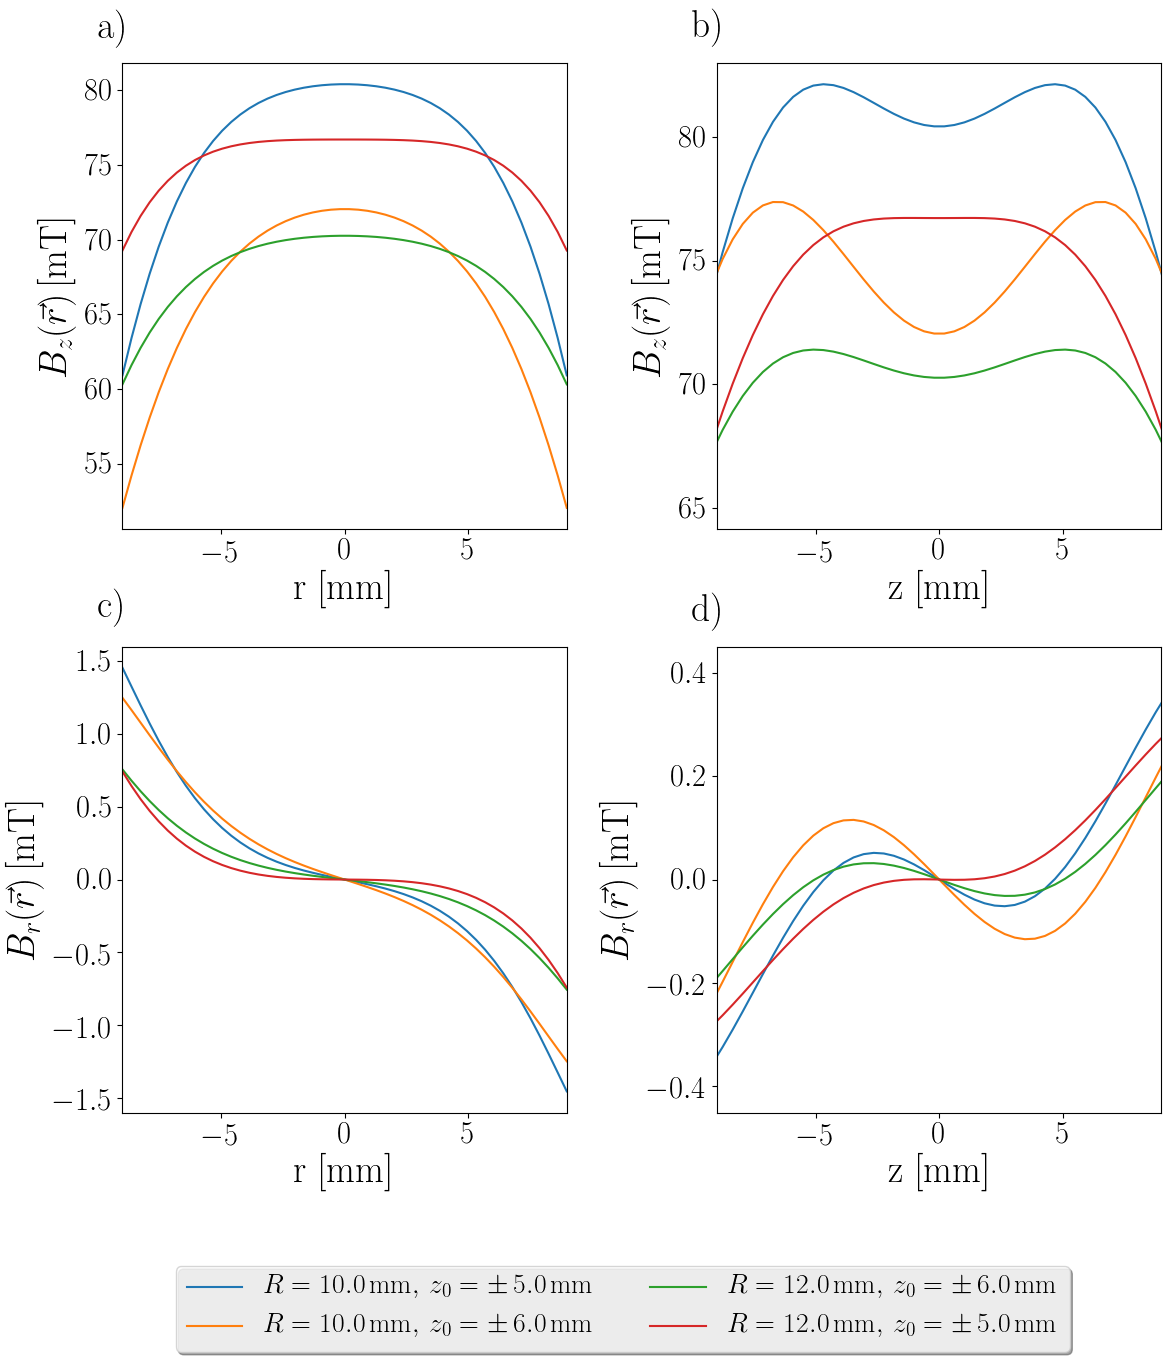

In [139]:
fig_1D = plt.figure(figsize =(12,12))

fig1D = plt.subplot(221)
#fig1D.set_aspect('equal')
#fig1title = fig1D.set_title(r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z0*10**3), fontsize = int(labelsize-5))
#fig1title.set_position([0.5,1.1])
fig1D.set_xlabel('r [mm]', fontsize = labelsize)
fig1D.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[mT]}$', fontsize = labelsize)
fig1D.set_xlim(-0.9*R*10**3,0.9*R*10**3)
#fig1D.set_ylim(-R*10**3,R*10**3)
#fig1D.axhline(z0*10**3, color = 'white')
#fig1D.axhline(-z0*10**3, color = 'white')
plt.plot(r02*10**3,B[0][numb]*10**3, label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z0*10**3))
plt.plot(r02*10**3,Bwgh[0][numb]*10**3,label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z_prime*10**3))
plt.plot(r02*10**3,Bwgh2[0][numb]*10**3, label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z_prime*10**3))
plt.plot(r02*10**3,BR2[0][numb]*10**3, label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z0*10**3))





z0_prime = z0+0.001

fig2D = plt.subplot(222)
#fig2D.set_aspect('equal')
#fig2title = fig2D.set_title(r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z0_prime*10**3), fontsize = int(labelsize-5))
#fig2title.set_position([0.5,1.1])
fig2D.set_xlabel('z [mm]', fontsize = labelsize)
fig2D.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[mT]}$', fontsize = labelsize)
fig2D.set_xlim(-0.9*R*10**3,0.9*R*10**3)
#fig2D.set_ylim(-R*10**3,R*10**3)
#fig2D.axhline(z0_prime*10**3, color = 'white')
#fig2D.axhline(-z0_prime*10**3, color = 'white')
plt.plot(z02*10**3,B[0][:,numb]*10**3, label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z0*10**3))
plt.plot(z02*10**3,Bwgh[0][:,numb]*10**3,label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z_prime*10**3))
plt.plot(z02*10**3,Bwgh2[0][:,numb]*10**3, label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z_prime*10**3))
plt.plot(z02*10**3,BR2[0][:,numb]*10**3, label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z0*10**3))



R_prime = R+0.002

fig3D = plt.subplot(223)
#fig3D.set_aspect('equal')
#fig3title = fig3D.set_title(r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z0*10**3), fontsize = int(labelsize-5))
#fig3title.set_position([0.5,1.1])
fig3D.set_xlabel('r [mm]', fontsize = labelsize)
fig3D.set_ylabel(r'$B_r(\vec{r})\,\mathrm{[mT]}$', fontsize = labelsize)
fig3D.set_xlim(-0.9*R*10**3,0.9*R*10**3)
#fig3D.set_ylim(-R*10**3,R*10**3)
plt.plot(r02*10**3,B[1][numb]*10**3, label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z0*10**3))
plt.plot(r02*10**3,Bwgh[1][numb]*10**3,label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z_prime*10**3))
plt.plot(r02*10**3,Bwgh2[1][numb]*10**3, label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z_prime*10**3))
plt.plot(r02*10**3,BR2[1][numb]*10**3, label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z0*10**3))



fig4D = plt.subplot(224)
#fig4D.set_aspect('equal')
#fig4title = fig4D.set_title(r'$B_r(\vec{r})\,\mathrm{[mT]}$', fontsize = int(labelsize-5))
#fig4title.set_position([0.5,1.1])
fig4D.set_xlabel('z [mm]', fontsize = labelsize)
fig4D.set_ylabel(r'$B_r(\vec{r})\,\mathrm{[mT]}$', fontsize = labelsize)
fig4D.set_xlim(-0.9*R*10**3,0.9*R*10**3)
#fig4D.set_ylim(-R*10**3,R*10**3)
plt.plot(z02*10**3,B[1][:,numb]*10**3, label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z0*10**3))
plt.plot(z02*10**3,Bwgh[1][:,numb]*10**3,label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R*10**3, z_prime*10**3))
plt.plot(z02*10**3,Bwgh2[1][:,numb]*10**3, label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z_prime*10**3))
plt.plot(z02*10**3,BR2[1][:,numb]*10**3, label = r'$R = {}\,\mathrm{{mm}},\,z_0 = \pm\,{}\,\mathrm{{mm}} $'.format(R_prime*10**3, z0*10**3))

fig1D.text(-10,83.5, 'a)', fontsize = labelsize )
fig2D.text(-10,84, 'b)', fontsize = labelsize )
fig3D.text(-10,1.8, 'c)', fontsize = labelsize )
fig4D.text(-10,0.5, 'd)', fontsize = labelsize )

plt.legend(loc = 'upper left', ncol = 2, bbox_to_anchor = (-1.25,-0.3), fontsize = 20)

plt.tight_layout()

In [141]:
#try: fig_1D.savefig('Brz_comparison_{}_{}.png'.format(str(n),str(n_layer)), dpi = 200)
#except: fig_1D.savefig('Brz_comparison_50_20.png', dpi = 200)

## Comparison to a single loop with current I = N*I

In [92]:
I_SL = n_layer*n*I_max

In [96]:
BSC = np.array(B_SC(r11,z11,z0, I_SL, R, N_acc)) + np.array(B_SC(r11,z11,-z0, I_SL, R, N_acc))

In [98]:
BSC2 = np.array(B_SC(r11,z11,z0, I_SL, R_prime, N_acc)) + np.array(B_SC(r11,z11,-z0, I_SL, R_prime, N_acc))

In [99]:
z02.shape

(50L,)

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


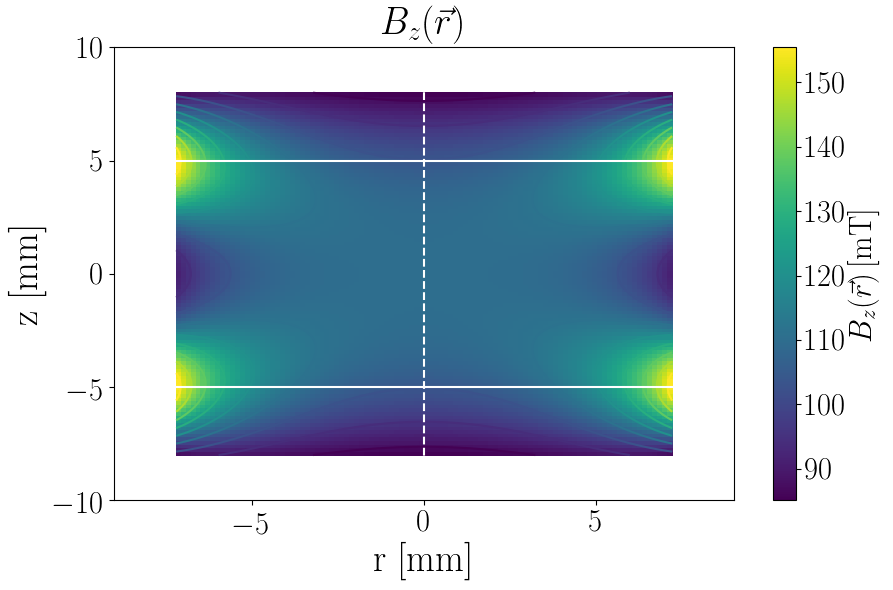

In [100]:
figBzSC_1000, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_z(\vec{r})$', fontsize = labelsize)
ax.set_xlabel('r [mm]', fontsize = labelsize)
ax.set_ylabel('z [mm]', fontsize = labelsize)
ax.set_xlim(-0.9*R*10**3,0.9*R*10**3)
ax.set_ylim(-R*10**3,R*10**3)
ax.axhline(z0*10**3, color = 'white')
ax.axhline(-z0*10**3, color = 'white')
ax.axvline(r01[N_sq/2.], color = 'white', ls = '--')
#ax.axes.set_aspect('equal')
CS = plt.contour(r11*10**3, z11*10**3, np.sqrt(BSC[0]**2.+BSC[1]**2.)*10**3,10)
cd = plt.pcolor(X01*10**3,Y01*10**3,BSC[0]*10**3, cmap=plt.get_cmap(cmaps.viridis))
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[mT]}$')
#plt.tight_layout()

In [336]:
#figBzSC_1000.savefig('BzSC_1000_equi.png', dpi = 200)

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


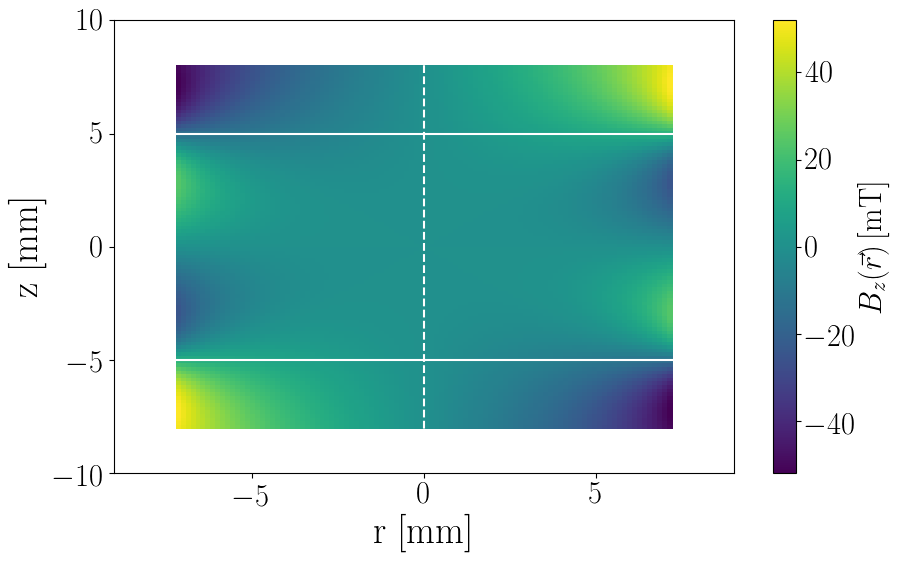

In [101]:
figBrSC_1000, ax = plt.subplots(figsize =(10,6))
#ax.set_title(r'$B_r(\vec{r})$', fontsize = labelsize)
ax.set_xlabel('r [mm]', fontsize = labelsize)
ax.set_ylabel('z [mm]', fontsize = labelsize)
ax.set_xlim(-0.9*R*10**3,0.9*R*10**3)
ax.set_ylim(-R*10**3,R*10**3)
ax.axhline(z0*10**3, color = 'white')
ax.axhline(-z0*10**3, color = 'white')
ax.axvline(r01[N_sq/2.], color = 'white', ls = '--')
#ax.axes.set_aspect('equal')
#CS = plt.contour(r11*10**3, z11*10**3, np.sqrt(BSC[0]**2.+BSC[1]**2.)*10**3,10)
cd = plt.pcolor(X01*10**3,Y01*10**3,BSC[1]*10**3, cmap=plt.get_cmap(cmaps.viridis))
cbar = plt.colorbar(cd)
cbar.ax.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[mT]}$')
#plt.tight_layout()

In [118]:
#figBrSC_1000.savefig('BrSC_1000.png', dpi = 200)

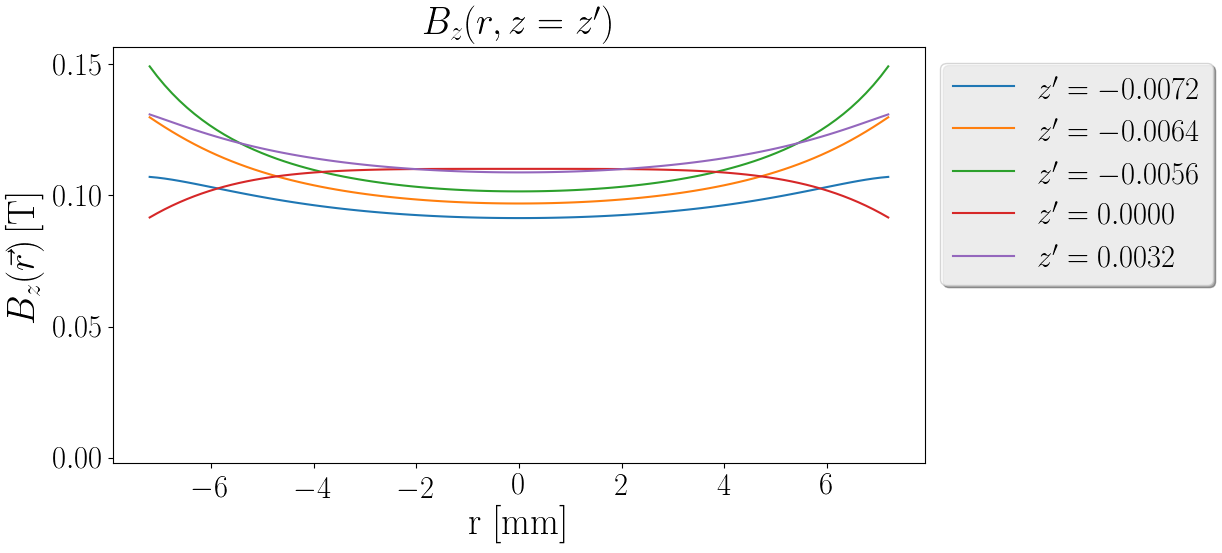

In [102]:
figBzrzSC, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_z(r, z = z^{\prime})$', fontsize = labelsize)
ax.set_xlabel('r [mm]', fontsize = labelsize)
ax.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[T]}$', fontsize = labelsize)
ax.axhline(z0, color = 'white', ls = '--')
#ax.axes.set_aspect('equal')
plt.plot(r11*10**3,BSC[0][5], label = r'$z^\prime = {}$'.format(truncate(z[5],4)))
plt.plot(r11*10**3,BSC[0][10],label = r'$z^\prime = {}$'.format(truncate(z[10],4)))
plt.plot(r11*10**3,BSC[0][15], label = r'$z^\prime = {}$'.format(truncate(z[15],4)))
if BSC.shape[2] >= 70:
    plt.plot(r11*10**3,BSC[0][50], label = r'$z^\prime = {}$'.format(truncate(z[50],4)))
    plt.plot(r11*10**3,BSC[0][70], label = r'$z^\prime = {}$'.format(truncate(z[70],4)))
plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.tight_layout()

In [103]:
#figBzrzSC.savefig('BzrzSC_1000.png', dpi = 200)

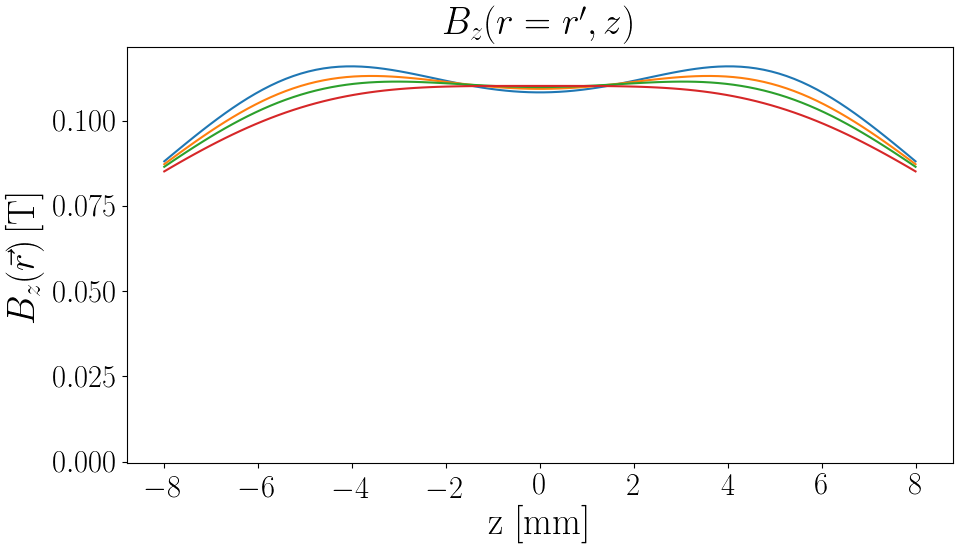

In [105]:
figBzzzSC, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_z(r = r^{\prime} , z)$', fontsize = labelsize)
ax.set_xlabel('z [mm]', fontsize = labelsize)
ax.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[T]}$', fontsize = labelsize)
ax.axhline(z0, color = 'white', ls = '--')
#ax.axes.set_aspect('equal')
plt.plot(z11*10**3,BSC[0][:,20], label = r'$r^\prime = {}$'.format(truncate(r[20],4)))
plt.plot(z11*10**3,BSC[0][:,25], label = r'$r^\prime = {}$'.format(truncate(r[25],4)))
plt.plot(z11*10**3,BSC[0][:,30], label = r'$r^\prime = {}$'.format(truncate(r[30],4)))
plt.plot(z11*10**3,BSC[0][:,50], label = r'$r^\prime = {}$'.format(truncate(r[50],4)))
#plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.tight_layout()

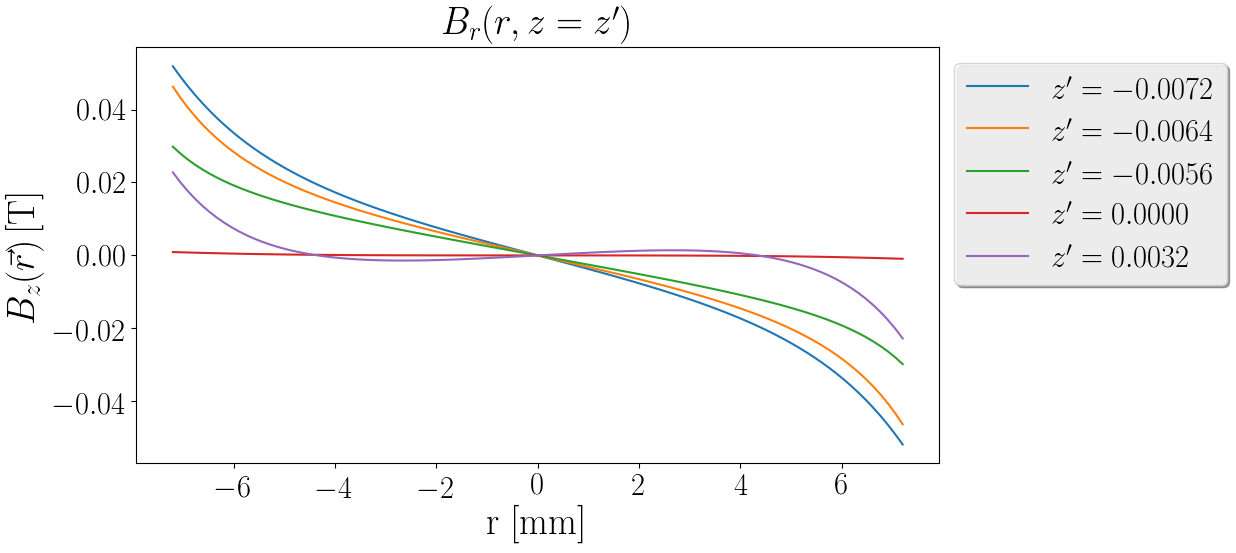

In [106]:
figBrrzSC, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_r(r, z = z^{\prime})$', fontsize = labelsize)
ax.set_xlabel('r [mm]', fontsize = labelsize)
ax.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[T]}$', fontsize = labelsize)
ax.axhline(z0, color = 'white', ls = '--')
#ax.axes.set_aspect('equal')
plt.plot(r11*10**3,BSC[1][5], label = r'$z^\prime = {}$'.format(truncate(z[5],4)))
plt.plot(r11*10**3,BSC[1][10],label = r'$z^\prime = {}$'.format(truncate(z[10],4)))
plt.plot(r11*10**3,BSC[1][15], label = r'$z^\prime = {}$'.format(truncate(z[15],4)))
if BSC.shape[2] >= 70:
    plt.plot(r11*10**3,BSC[1][50], label = r'$z^\prime = {}$'.format(truncate(z[50],4)))
    plt.plot(r11*10**3,BSC[1][70], label = r'$z^\prime = {}$'.format(truncate(z[70],4)))
plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.tight_layout()

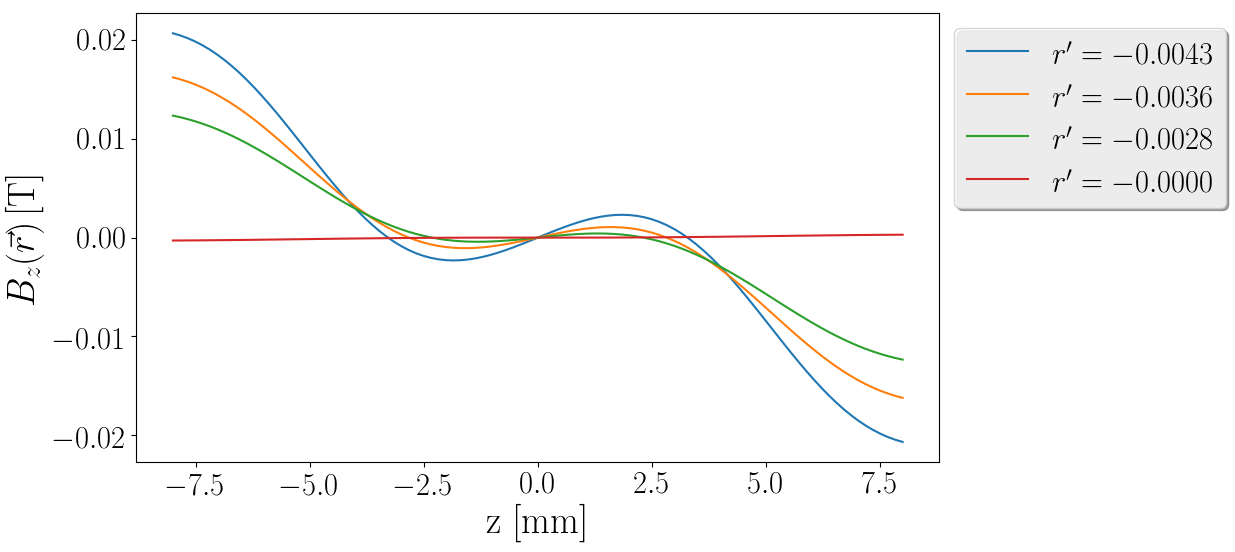

In [107]:
figBrzzSC, ax = plt.subplots(figsize =(10,6))
#ax.set_title(r'$B_r(r = r^{\prime} , z)$', fontsize = labelsize)
ax.set_xlabel('z [mm]', fontsize = labelsize)
ax.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[T]}$', fontsize = labelsize)
ax.axhline(z0, color = 'white', ls = '--')
#ax.axes.set_aspect('equal')
plt.plot(z11*10**3,BSC[1][:,20], label = r'$r^\prime = {}$'.format(truncate(r[20],4)))
plt.plot(z11*10**3,BSC[1][:,25], label = r'$r^\prime = {}$'.format(truncate(r[25],4)))
plt.plot(z11*10**3,BSC[1][:,30], label = r'$r^\prime = {}$'.format(truncate(r[30],4)))
plt.plot(z11*10**3,BSC[1][:,50], label = r'$r^\prime = {}$'.format(truncate(r[50],4)))
plt.legend(loc = 'upper left', bbox_to_anchor = (1,1))
plt.tight_layout()

### simple Helmholtz model:

In [108]:
def Bz_simpleHH(z,z0, n_tot, I, R):
    '''on-axis field (z-direction) of a single loop along the symmetry axis z
    
    n_tot: total number of windings
    I: current in amps'''
    B = mu_0*n_tot*I*R**2./(2.*(R**2.+(z-z0)**2.)**(3./2.))
    return B

In [109]:
B_comp = Bz_simpleHH(z11, z0, n_layer*n, I, R) + Bz_simpleHH(z11, -z0, n_layer*n, I, R)

In [110]:
B_comp_z0 = Bz_simpleHH(z11, z0_prime, n_layer*n, I, R) + Bz_simpleHH(z11, -z0_prime, n_layer*n, I, R)

In [111]:
B_comp_R = Bz_simpleHH(z11, z0, n_layer*n, I, R_prime) + Bz_simpleHH(z11, -z0, n_layer*n, I, R_prime)

In [112]:
B_comp_Rz0 = Bz_simpleHH(z11, z0_prime, n_layer*n, I, R_prime) + Bz_simpleHH(z11, -z0_prime, n_layer*n, I, R_prime)

In [113]:
R2 = 0.007

In [114]:
B_comp_z02 = Bz_simpleHH(z11, z0_prime, n_layer*n, I, R2) + Bz_simpleHH(z11, -z0_prime, n_layer*n, I, R2)

In [115]:
z0_prime

0.006

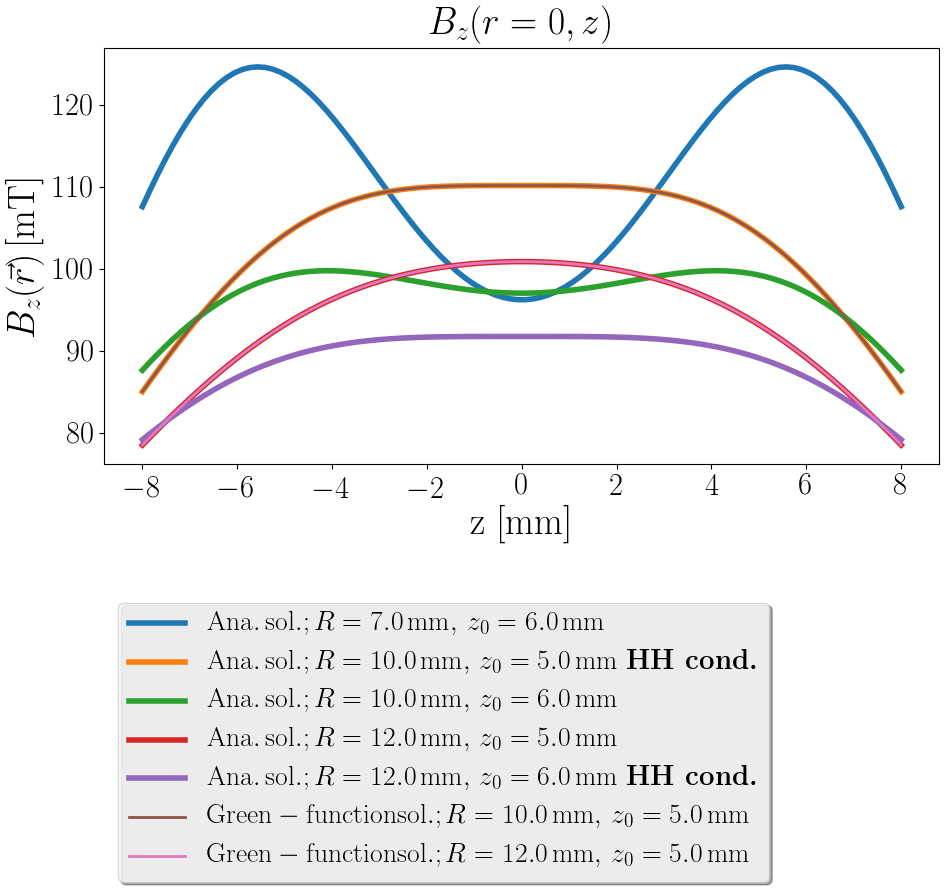

In [116]:
figBzcomp, ax = plt.subplots(figsize =(10,6))
ax.set_title(r'$B_z(r = 0, z)$', fontsize = labelsize)
ax.set_xlabel('z [mm]', fontsize = labelsize)
ax.set_ylabel(r'$B_z(\vec{r})\,\mathrm{[mT]}$', fontsize = labelsize)
#ax.axhline(z0, color = 'white', ls = '--')
ax.plot(z11*10**3, B_comp_z02*10**3, label = r'$\mathrm{{Ana.\,sol.;}}\,R = {}\,\mathrm{{mm}},\,z_0 = {}\,\mathrm{{mm}}$'.format(R2*10**3, z0_prime*10**3), lw = 4.)
ax.plot(z11*10**3, B_comp*10**3, label = r'$\mathrm{{Ana.\,sol.;}}\,R = {}\,\mathrm{{mm}},\,z_0 = {}\,\mathrm{{mm}}$ \textbf{{HH cond.}}'.format(R*10**3, z0*10**3), lw = 4.)
ax.plot(z11*10**3, B_comp_z0*10**3, label = r'$\mathrm{{Ana.\,sol.;}}\,R = {}\,\mathrm{{mm}},\,z_0 = {}\,\mathrm{{mm}}$'.format(R*10**3., z0_prime*10**3), lw = 4.)
ax.plot(z11*10**3, B_comp_R*10**3, label = r'$\mathrm{{Ana.\,sol.;}}\,R = {}\,\mathrm{{mm}},\,z_0 = {}\,\mathrm{{mm}}$'.format(R_prime*10**3, z0*10**3), lw = 4.)
ax.plot(z11*10**3, B_comp_Rz0*10**3, label = r'$\mathrm{{Ana.\,sol.;}}\,R = {}\,\mathrm{{mm}},\,z_0 = {}\,\mathrm{{mm}}$ \textbf{{HH cond.}}'.format(R_prime*10**3., z0_prime*10**3), lw = 4.)
ax.plot(z11*10**3,BSC[0][:,50]*10**3, label = r'$\mathrm{{Green-function sol.;}}\,R = {}\,\mathrm{{mm}},\,z_0 = {}\,\mathrm{{mm}}$'.format(R*10**3, z0*10**3), lw = 2.)
ax.plot(z11*10**3,BSC2[0][:,50]*10**3, label = r'$\mathrm{{Green-function sol.;}}\,R = {}\,\mathrm{{mm}},\,z_0 = {}\,\mathrm{{mm}}$'.format(R_prime*10**3, z0*10**3), lw = 2.)
plt.legend(loc = 'upper left', bbox_to_anchor = (0,-0.3), fontsize = 20)
plt.tight_layout()
plt.show()

In [98]:
#figBzcomp.savefig('Bzcomp.png', dpi = 200)